# **Donwload Dataset**

In [ ]:
!curl -o ETTh1.csv https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 2528k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 20 2528k   20  512k    0     0   308k      0  0:00:08  0:00:01  0:00:07  308k
 35 2528k   35  907k    0     0   341k      0  0:00:07  0:00:02  0:00:05  341k
 59 2528k   59 1510k    0     0   413k      0  0:00:06  0:00:03  0:00:03  413k
 86 2528k   86 2193k    0     0   471k      0  0:00:05  0:00:04  0:00:01  471k
100 2528k  100 2528k    0     0   503k      0  0:00:05  0:00:05 --:--:--  584k


# **Import Packages**

In [ ]:
!pip install -U kaleido

In [ ]:
import os
import time
import numpy as np
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from xgboost import XGBRegressor

c:\Users\neko941\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Utils**

In [ ]:
class TimeSeriesDataLoader:
    def __init__(self, file_path, input_size, label_size, offset, train_size, val_size, date_column=None, target_name=None, features_type='M', batch_size=64):
        if offset < label_size:
            print(f"Offset will be change from {offset} to {label_size}")
            offset = label_size

        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset
        self.train_size = train_size
        self.val_size = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size

        # Load the data
        self.df = pl.read_csv(file_path)
        if date_column is not None: self.df = self.df.drop('date')

        # Determine in_variable and out_variable based on features_type
        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            self.out_variable = len(self.df.columns)
        elif features_type == 'MS':
            self.in_variable = len(self.df.columns)
            self.out_variable = 1
        else:
            raise ValueError("Invalid features_type. Choose from 'S' for Univariate-to-Univariate, 'M' for Multivariate-to-Multivariate, 'MS' for Multivariate-to-Univariate.")

        # Preprocess the data
        self.X_train, self.y_train = self.__create_dataset(0, int(train_size * len(self.df)))
        print(f'{self.X_train.shape = }')
        print(f'{self.y_train.shape = }')
        self.X_val, self.y_val = self.__create_dataset(int(train_size * len(self.df)), int((train_size + val_size) * len(self.df)))
        print(f'{self.X_val.shape = }')
        print(f'{self.y_val.shape = }')
        self.X_test, self.y_test = self.__create_dataset(int((train_size + val_size) * len(self.df)), None)
        print(f'{self.X_test.shape = }')
        print(f'{self.y_test.shape = }')

        # Convert to PyTorch DataLoaders
        self.train_loader = self.__create_dataloader(self.X_train, self.y_train)
        self.val_loader = self.__create_dataloader(self.X_val, self.y_val)
        self.test_loader = self.__create_dataloader(self.X_test, self.y_test)

    def __create_dataset(self, start_idx, end_idx):
        if end_idx is None:
            end_idx = len(self.df) - self.label_size - self.offset

        start_idx += self.input_size + self.offset

        features = []
        labels = []

        for idx in range(start_idx, end_idx):
            feature_start_idx = idx - self.input_size - self.offset
            feature_end_idx = feature_start_idx + self.input_size

            label_start_idx = idx - 1
            label_end_idx = label_start_idx + self.label_size

            if self.features_type == 'S':
                feature = self.df.select(self.target_name)[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            elif self.features_type == 'M':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df[label_start_idx:label_end_idx]
            elif self.features_type == 'MS':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            else:
                raise ValueError("Invalid features_type. Choose from 'S', 'M', 'MS'.")

            features.append(feature.to_numpy())
            labels.append(label.to_numpy())
            self.out_features = label.columns
            self.in_features = label.columns

        return np.array(features), np.array(labels)

    def __create_dataloader(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

In [ ]:
import torch
import torch.nn as nn

class ModelManager:
    def __init__(self, model, train_loader, val_loader=None, lr=0.001, patience=100):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()  # Set the model to training mode
            total_train_loss = 0

            for inputs, targets in self.train_loader:
                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_train_loss += loss.item()

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            avg_train_loss = total_train_loss / len(self.train_loader)

            # Validate the model
            val_loss = self.evaluate(loader=self.val_loader)

            # Check for early stopping
            if self.early_stopping(val_loss, save_path):
                print(f"Early stopping at epoch {epoch + 1}")
                return

            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'time: {int(time.time() - start_time)}s, '
                  f'loss: {avg_train_loss:.4f}, '
                  f'val_loss: {val_loss:.4f}')

        self.load_model(save_path)

    def evaluate(self, loader):
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        return avg_loss

    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f'Model loaded from {load_path}')

    def predict(self, input_data):
        self.model.eval()  # Set the model to evaluation mode

        if isinstance(input_data, DataLoader):
            # If input_data is a DataLoader, iterate through batches and concatenate predictions
            predictions = []
            with torch.no_grad():
                for inputs, _ in input_data:
                    outputs = self.model(inputs)
                    predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        else:
            # Assume input_data is a single input tensor
            with torch.no_grad():
                predictions = self.model(input_data).unsqueeze(0)

        return predictions

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None:
            feature_names = [f'Feature {i + 1}' for i in range(y.shape[2])]

        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10, 5))

            plt.plot(y[:, :, feature_index].flatten(), label='y', linestyle='-')
            plt.plot(yhat[:, :, feature_index].flatten(), label='y_hat', linestyle='--')

            plt.title(feature_name)
            plt.xlabel('Time Step')
            plt.ylabel('Values')
            plt.legend()

            if save_plots:
                # Create the save directory if it doesn't exist
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)

                # Save the plot
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
                plt.savefig(save_path)

            plt.show()
            plt.close()  # Close the plot to avoid overlapping in saved images

class MachineLearningModelManager(ModelManager):
    def __init__(self, model, xtrain, ytrain, xval, yval):
        self.model = model
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xval = xval
        self.yval = yval

    def preprocessing(self, x):
        return x.reshape(x.shape[0], -1)

    def save_model(self, save_path):
        import pickle
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.model, model_file)
        print(f'Model saved to {save_path}')

    def train(self, save_dir='.'):
        self.model.fit(self.preprocessing(self.xtrain),
                       self.preprocessing(self.ytrain),
                       eval_set=[(self.preprocessing(self.xval), self.preprocessing(self.yval))])
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pkl')
        self.save_model(save_path=save_path)

    def predict(self, x):
        return self.model.predict(self.preprocessing(x))

    def evaluate(self, x, y):
        from sklearn.metrics import mean_absolute_error
        # print(self.preprocessing(y).shape)
        # print(self.predict(self.preprocessing(x)).shape)
        return mean_absolute_error(self.preprocessing(y), self.predict(self.preprocessing(x)))

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        yhat = yhat.reshape(y.shape[0], y.shape[1], -1)
        super().plot(y, yhat, feature_names=feature_names, save_dir=save_dir, save_plots=save_plots, num_elements=num_elements)

# **Models**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, ahead):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size * ahead)  # Adjust for output sequence length
        self.ahead = ahead
        self.output_size = output_size

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Reshape from [batch, lag, features] to [batch, lag * features]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.view(-1, self.ahead, self.output_size)  # Reshape to [batch, ahead, features]

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # RNN Layer - can be replaced with nn.LSTM or nn.GRU
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Output layer
        # Output size is doubled because BiLSTM has two hidden states for each layer
        self.fc = nn.Linear(hidden_size * 2, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate BiLSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out


# **Configs**

In [ ]:
input_size = 336
label_size = 96
offset = 1
train_size = 0.7
val_size = 0.1
num_epochs = 1_000_000
patience = 20
learning_rate = 0.001
hidden_size = 64
num_layers = 2
ele = 5
target_name = 'OT'
date_column = 'date'
file_path = 'ETTh1.csv'
plot_dir = 'plots'
weight_dir = 'weights'
results = []

In [ ]:
xgboost_config = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'booster': 'gbtree',
    'n_estimators': num_epochs,
    'max_depth': 3,
    'learning_rate': 0.1,
    'early_stopping_rounds': patience
}

# **EDA**

In [ ]:
train_df = pl.read_csv(file_path)

In [ ]:
train_df.describe()

shape: (7, 9)
┌────────────┬────────────┬────────────┬──────────┬───┬──────────┬──────────┬──────────┬───────────┐
│ describe   ┆ date       ┆ HUFL       ┆ HULL     ┆ … ┆ MULL     ┆ LUFL     ┆ LULL     ┆ OT        │
│ ---        ┆ ---        ┆ ---        ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---       │
│ str        ┆ str        ┆ f64        ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64       │
╞════════════╪════════════╪════════════╪══════════╪═══╪══════════╪══════════╪══════════╪═══════════╡
│ count      ┆ 17420      ┆ 17420.0    ┆ 17420.0  ┆ … ┆ 17420.0  ┆ 17420.0  ┆ 17420.0  ┆ 17420.0   │
│ null_count ┆ 0          ┆ 0.0        ┆ 0.0      ┆ … ┆ 0.0      ┆ 0.0      ┆ 0.0      ┆ 0.0       │
│ mean       ┆ null       ┆ 7.375141   ┆ 2.242242 ┆ … ┆ 0.881568 ┆ 3.066062 ┆ 0.856932 ┆ 13.324672 │
│ std        ┆ null       ┆ 7.067744   ┆ 2.042342 ┆ … ┆ 1.809293 ┆ 1.164506 ┆ 0.599552 ┆ 8.566946  │
│ min        ┆ 2016-07-01 ┆ -22.705999 ┆ -4.756   ┆ … ┆ -5.934   ┆ -1.188   ┆ -1.371   ┆ -4.08     │
│            ┆ 00:00:00   ┆            ┆          ┆   ┆          ┆          ┆          ┆           │
│ max        ┆ 2018-06-26 ┆ 23.643999  ┆ 10.114   ┆ … ┆ 7.747    ┆ 8.498    ┆ 3.046    ┆ 46.007    │
│            ┆ 19:00:00   ┆            ┆          ┆   ┆          ┆          ┆          ┆           │
│ median     ┆ null       ┆ 8.774      ┆ 2.21     ┆ … ┆ 0.959    ┆ 2.833    ┆ 0.975    ┆ 11.396    │
└────────────┴────────────┴────────────┴──────────┴───┴──────────┴──────────┴──────────┴───────────┘

In [ ]:
import polars as pl
pl.Config.set_tbl_cols(100)
summary_df = []

for column_name in train_df.columns:
    col = train_df[column_name]

    dtype = str(col.dtype)
    missing_values = col.is_null().sum()
    missing_ratio = missing_values / len(train_df)
    unique_values = col.n_unique()
    unique_ratio = unique_values / len(train_df)

    # Get the most frequent value and its count
    value_counts = col.value_counts()
    most_freq_value_index = value_counts[column_name][0]
    most_freq_value_count = value_counts["counts"][0]
    most_freq_value_ratio = most_freq_value_count / len(train_df)

    summary_row = {
        'Name': column_name,
        'DType': dtype,
        'MissingValues': missing_values,
        'MissingValuesRatio': missing_ratio,
        'UniqueValues': unique_values,
        'UniqueValuesRatio': unique_ratio,
        'MostFreqValue': most_freq_value_index,
        'MostFreqValueCount': most_freq_value_count,
        'MostFreqValueCountRatio': most_freq_value_ratio
    }

    summary_df.append(summary_row)

print(pl.from_dicts(summary_df))


shape: (8, 9)
┌──────┬─────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ Name ┆ DType   ┆ MissingVal ┆ MissingVal ┆ UniqueValu ┆ UniqueValu ┆ MostFreqVa ┆ MostFreqVa ┆ MostFreqVa │
│ ---  ┆ ---     ┆ ues        ┆ uesRatio   ┆ es         ┆ esRatio    ┆ lue        ┆ lueCount   ┆ lueCountRa │
│ str  ┆ str     ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ tio        │
│      ┆         ┆ i64        ┆ f64        ┆ i64        ┆ f64        ┆ str        ┆ i64        ┆ ---        │
│      ┆         ┆            ┆            ┆            ┆            ┆            ┆            ┆ f64        │
╞══════╪═════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ date ┆ Utf8    ┆ 0          ┆ 0.0        ┆ 17420      ┆ 1.0        ┆ 2016-11-20 ┆ 1          ┆ 0.000057   │
│      ┆         ┆            ┆            ┆            ┆            ┆ 07:00:00   ┆            ┆          

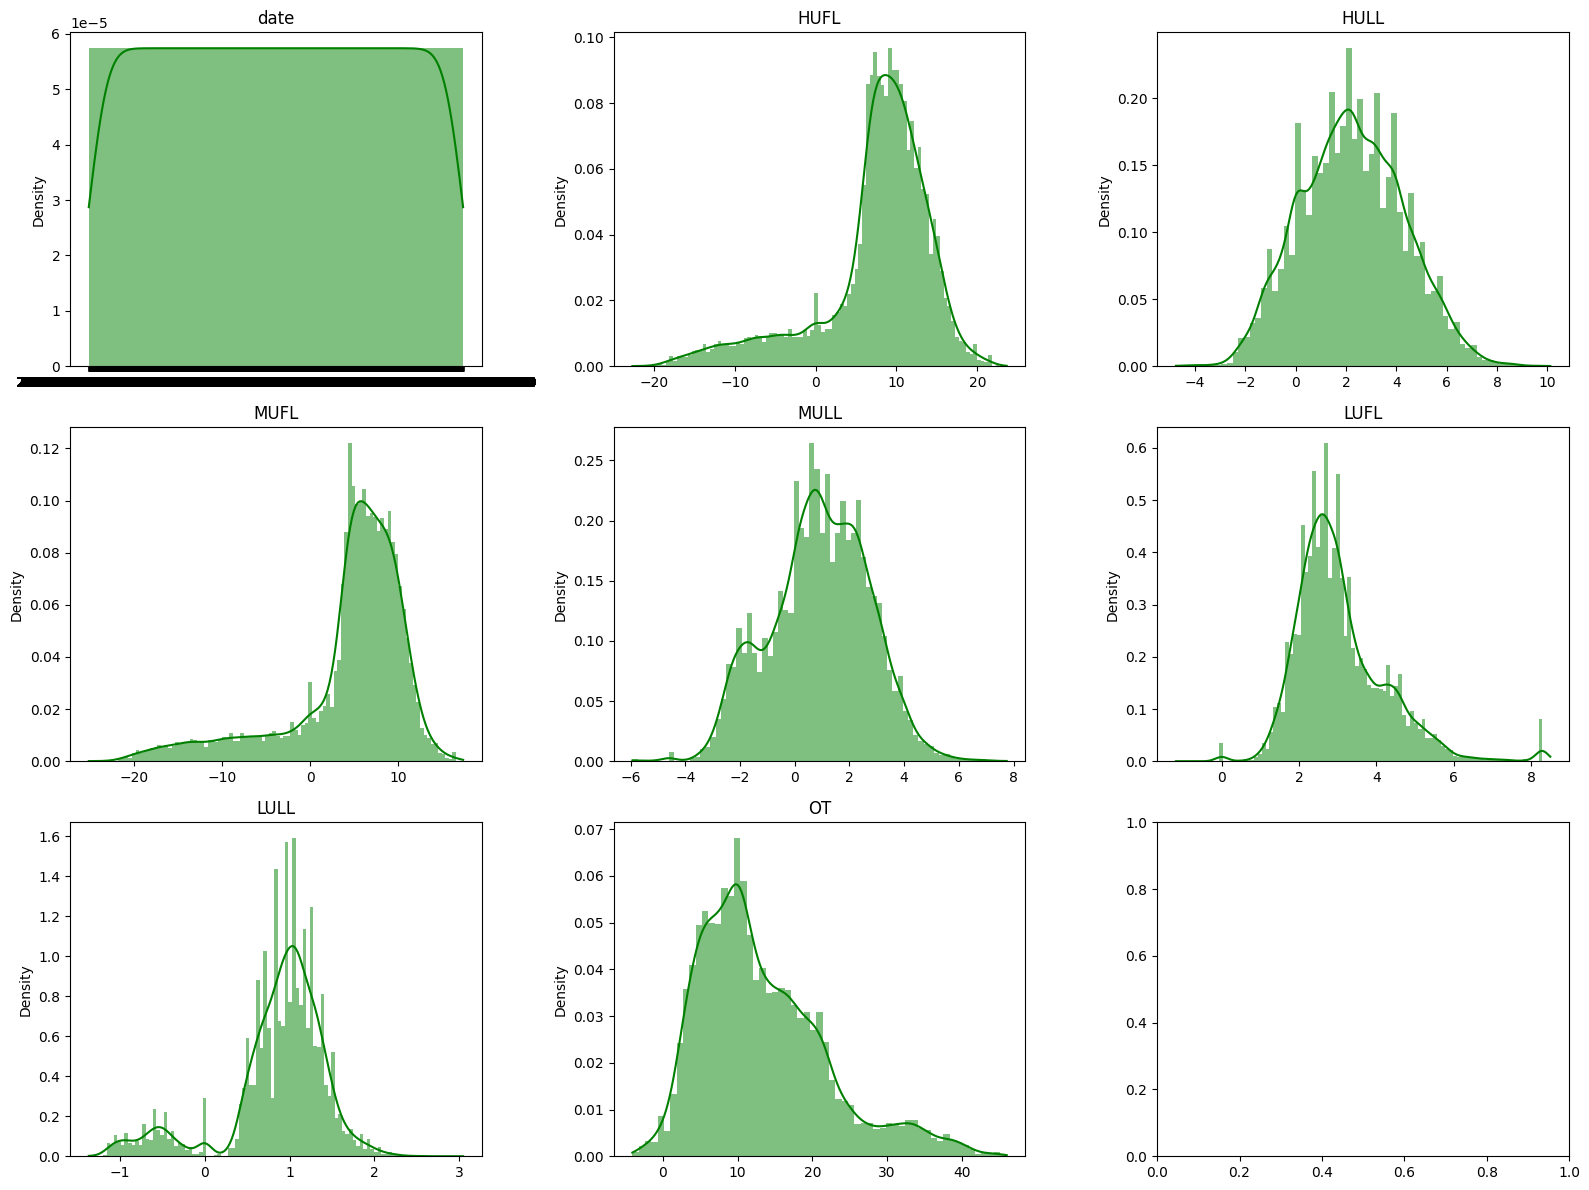

In [ ]:
columns_to_plot = train_df.columns

num_columns = 3
num_rows = int(np.ceil(len(columns_to_plot) / num_columns))
grid_layout = (num_rows, num_columns)

fig, axes = plt.subplots(*grid_layout, figsize=(16, 12))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(train_df[column], kde=True, ax=axes[i],
                 color='green', stat="density", linewidth=0)
    axes[i].set_title(column)
plt.tight_layout()
plt.show()

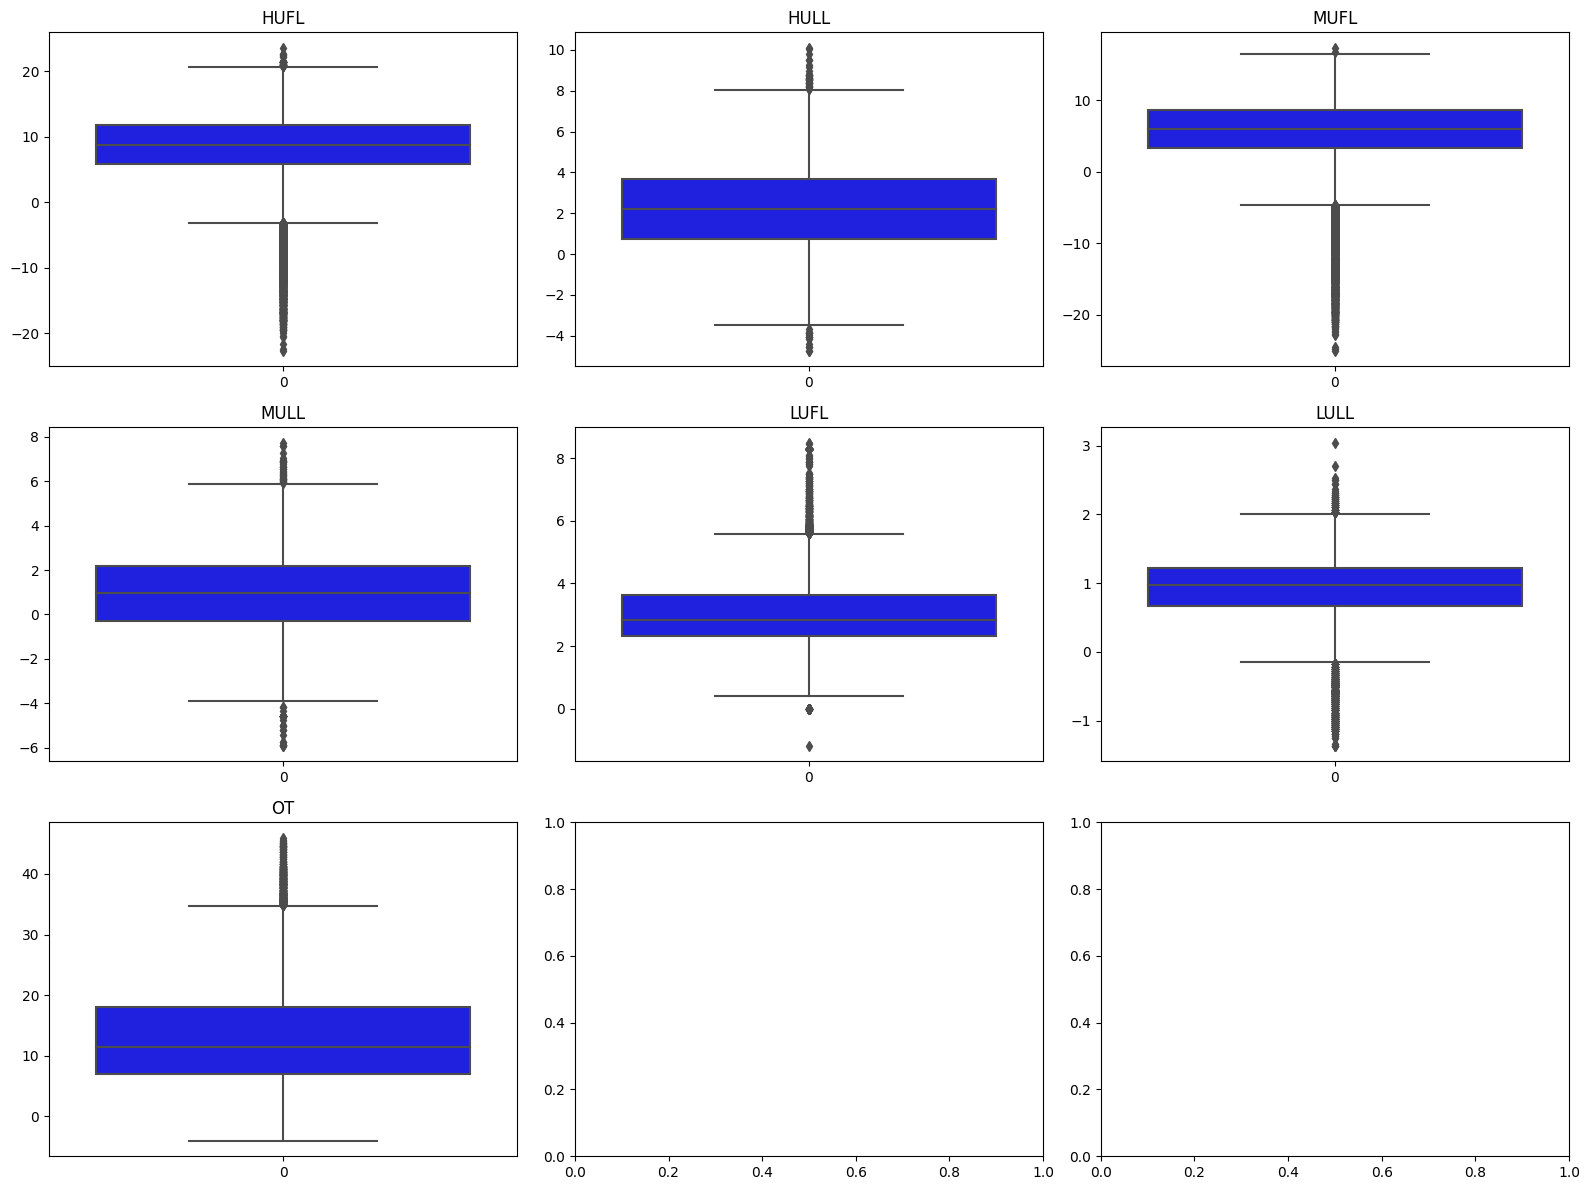

In [ ]:
columns_to_plot = [c for c in train_df.columns if c != date_column]

num_columns = 3
num_rows = int(np.ceil(len(columns_to_plot) / num_columns))
grid_layout = (num_rows, num_columns)

fig, axes = plt.subplots(*grid_layout, figsize=(16, 12))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=train_df[column], ax=axes[i], color='blue')
    axes[i].set_title(column)


plt.tight_layout()
plt.show()

C:\Users\neko941\AppData\Local\Temp\ipykernel_37388\4001534857.py:26: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_corr = train.corr(method="pearson")


<Axes: >

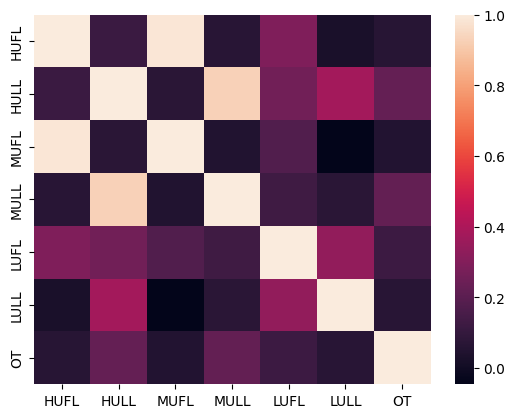

In [ ]:
# import plotly.graph_objects as go
# from IPython.display import Image
# from pathlib import Path

# def save_and_show_fig(fig, filename, /, img_dir=None, format="png"):
#     if img_dir is None:
#         img_dir = Path("images")
#     if not isinstance(img_dir, Path):
#         raise TypeError("The `img_dir` argument must be `Path` instance!")

#     img_dir.mkdir(parents=True, exist_ok=True)
#     fig_path = img_dir / (filename + "." + format)
#     fig.write_image(fig_path)

#     return Image(fig.to_image(format=format))

# def get_lower_triangular_frame(frame, /):
#     if not frame.shape[0] == frame.shape[1]:
#         raise ValueError(f"{type(frame)!r} is not square frame")
#     lower_triu = np.triu(np.ones_like(frame, dtype=bool))
#     frame = frame.mask(lower_triu)
#     return frame.dropna(axis="index", how="all").dropna(axis="columns", how="all")

train = train_df.to_pandas()
# print("dasdad")
pearson_corr = train.corr(method="pearson")
sns.heatmap(pearson_corr)
# print("dasdad")
# lower_triu_corr = get_lower_triangular_frame(pearson_corr)
# print("dasdad")
# COLOR_SCHEME = np.array(("#4A4B52", "#FCFCFC", "#E8BA91"))
# colormap = tuple(zip((0, 0.5, 1), COLOR_SCHEME[[1, 0, 2]]))

# heatmap = go.Heatmap(
#     z=lower_triu_corr,
#     x=lower_triu_corr.columns,
#     y=lower_triu_corr.index,
#     text=lower_triu_corr.fillna(""),
#     texttemplate="%{text:.2f}",
#     xgap=4,
#     ygap=4,
#     showscale=True,
#     colorscale=colormap,
#     colorbar_len=1.02,
#     hoverinfo="none",
# )
# fig = go.Figure(heatmap)
# fig.update_layout(
#     title="Dataset - Lower Triangle of Correlation Matrix (Pearson)<br>",
#     yaxis_autorange="reversed",
#     width=840,
#     height=840,
# )
# save_and_show_fig(fig, "pearson_corr_matrix")

In [ ]:
# def get_n_rows_and_axes(n_features, n_cols, /, start_at=1):
#     n_rows = int(np.ceil(n_features / n_cols))
#     current_col = range(start_at, n_cols + start_at)
#     current_row = range(start_at, n_rows + start_at)
#     return n_rows, tuple(product(current_row, current_col))

# columns_to_plot = train_df.columns
# n_cols = 3
# n_features = int(np.ceil(len(columns_to_plot) / n_cols))
# n_rows, axes = get_n_rows_and_axes(n_features, n_cols)


# **Multivariate-to-Multivartiate**

In [ ]:
features_type='M'
sub_dir = 'multi2multi'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2multi_loader = TimeSeriesDataLoader(file_path,
                                          input_size=input_size,
                                          label_size=label_size,
                                          offset=offset,
                                          train_size=train_size,
                                          val_size=val_size,
                                          target_name=target_name,
                                          features_type=features_type,
                                          date_column=date_column)

Offset will be change from 1 to 96
self.X_train.shape = (11762, 336, 7)
self.y_train.shape = (11762, 96, 7)
self.X_val.shape = (1309, 336, 7)
self.y_val.shape = (1309, 96, 7)
self.X_test.shape = (2861, 336, 7)
self.y_test.shape = (2861, 96, 7)


### **MLP**

In [ ]:
MLP_multi2multi = MLP(input_size=multi2multi_loader.in_variable*input_size,
                      hidden_size=hidden_size,
                      output_size=multi2multi_loader.out_variable,
                      ahead=label_size)
MLP_multi2multi_manager = ModelManager(model=MLP_multi2multi,
                                       train_loader=multi2multi_loader.train_loader,
                                       val_loader=multi2multi_loader.val_loader,
                                       lr=learning_rate,
                                       patience=patience)
MLP_multi2multi_manager.train(num_epochs=num_epochs,
                              save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": MLP_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": MLP_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

Model saved to weights\multi2multi\best-MLP.pth
Epoch [1/1000000], time: 0s, loss: 3.0666, val_loss: 3.6309
Model saved to weights\multi2multi\best-MLP.pth
Epoch [2/1000000], time: 0s, loss: 2.3158, val_loss: 3.4847
Model saved to weights\multi2multi\best-MLP.pth
Epoch [3/1000000], time: 0s, loss: 2.1646, val_loss: 3.1786
Model saved to weights\multi2multi\best-MLP.pth
Epoch [4/1000000], time: 0s, loss: 2.0726, val_loss: 2.9381
Model saved to weights\multi2multi\best-MLP.pth
Epoch [5/1000000], time: 0s, loss: 1.9253, val_loss: 2.9115
Model saved to weights\multi2multi\best-MLP.pth
Epoch [6/1000000], time: 0s, loss: 1.8386, val_loss: 2.6495
Model saved to weights\multi2multi\best-MLP.pth
Epoch [7/1000000], time: 0s, loss: 1.7789, val_loss: 2.5065
Model saved to weights\multi2multi\best-MLP.pth
Epoch [8/1000000], time: 0s, loss: 1.7591, val_loss: 2.4645
Model saved to weights\multi2multi\best-MLP.pth
Epoch [9/1000000], time: 0s, loss: 1.7523, val_loss: 2.4465
Model saved to weights\multi

{'Name': 'MLP', 'Type': 'multi2multi', 'MAE': 2.4726001686520047}

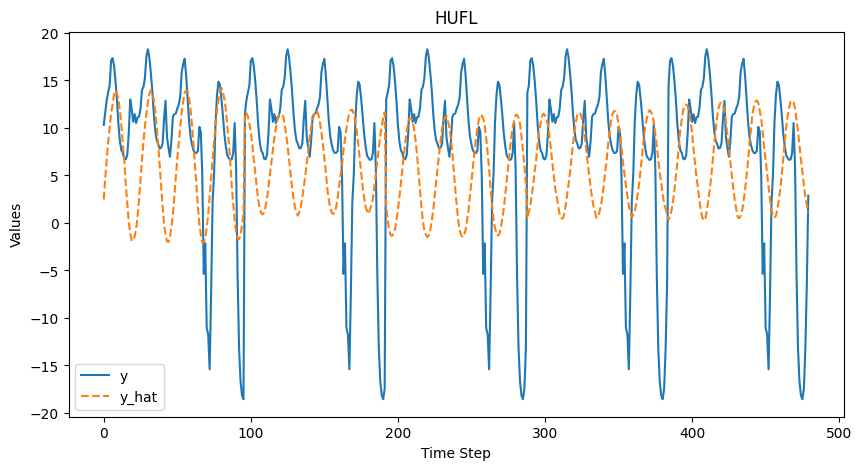

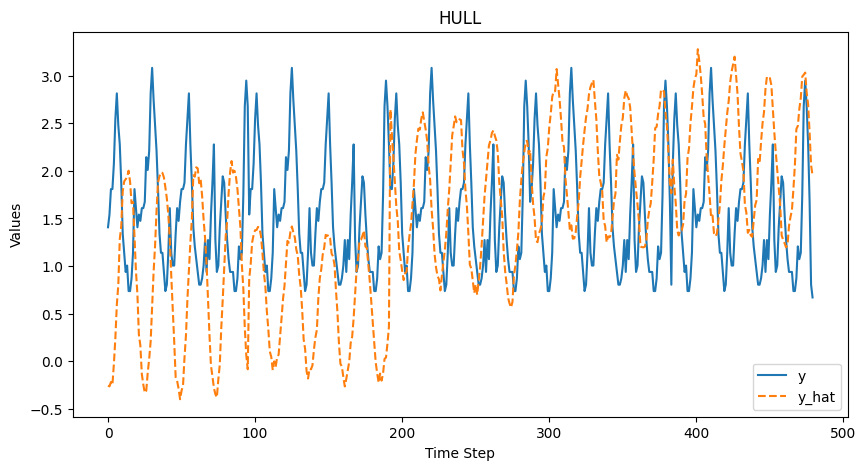

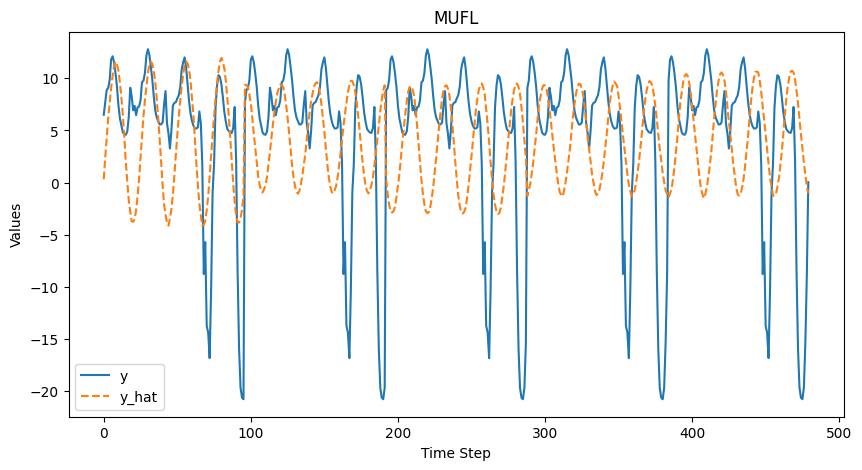

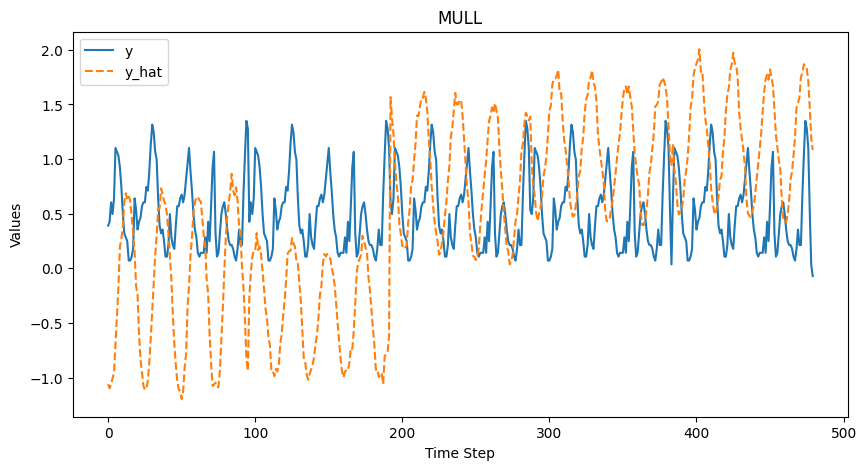

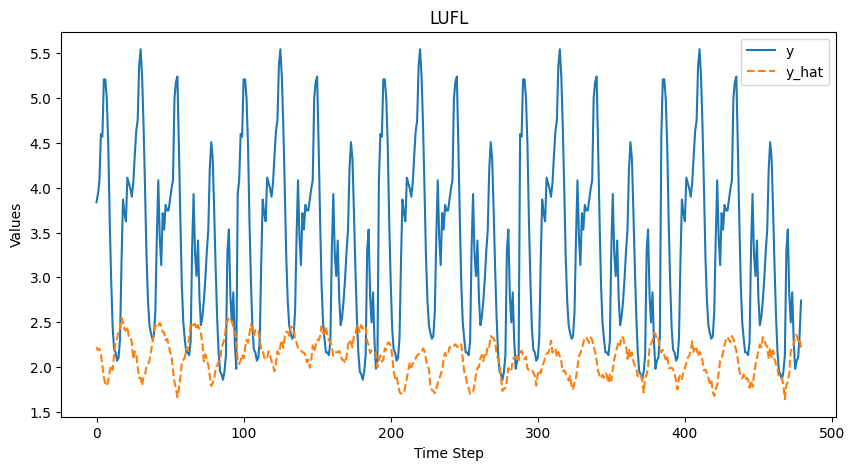

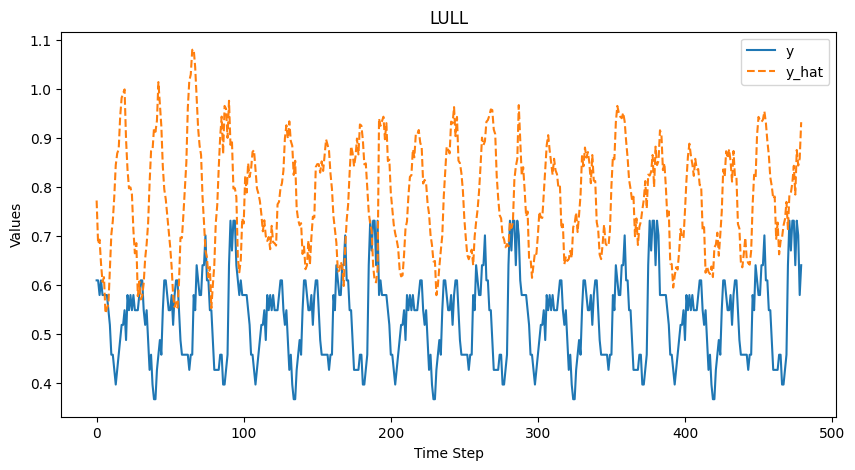

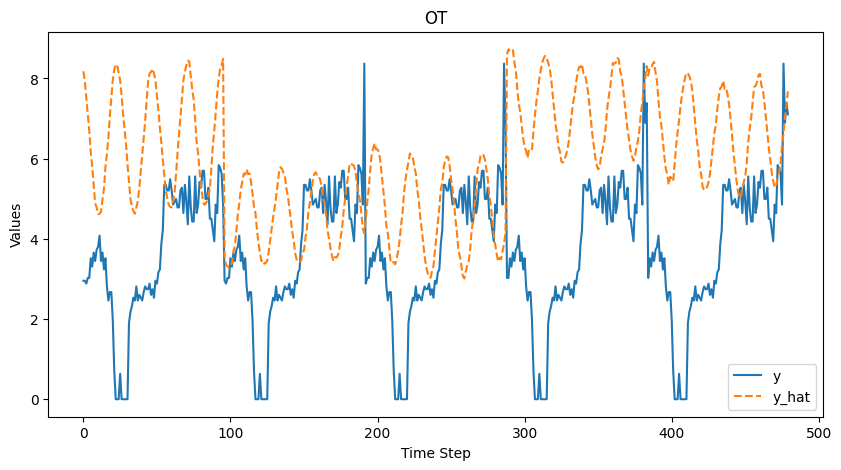

In [ ]:
MLP_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                             yhat=MLP_multi2multi_manager.predict(multi2multi_loader.test_loader),
                             feature_names=multi2multi_loader.out_features,
                             save_dir=os.path.join(plot_dir, sub_dir),
                             save_plots=True,
                             num_elements=ele)

### **RNN**

In [ ]:
RNN_multi2multi = RNN(input_size=multi2multi_loader.in_variable,
                      hidden_size=hidden_size,
                      output_size=multi2multi_loader.out_variable,
                      ahead=label_size,
                      num_layers=num_layers)
RNN_multi2multi_manager = ModelManager(model=RNN_multi2multi,
                                       train_loader=multi2multi_loader.train_loader,
                                       val_loader=multi2multi_loader.val_loader,
                                       lr=learning_rate,
                                       patience=patience)
RNN_multi2multi_manager.train(num_epochs=num_epochs,
                              save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": RNN_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

Model saved to weights\multi2multi\best-RNN.pth
Epoch [1/1000000], time: 13s, loss: 3.6460, val_loss: 3.0935
Epoch [2/1000000], time: 13s, loss: 2.7756, val_loss: 3.5840
Epoch [3/1000000], time: 13s, loss: 2.6845, val_loss: 3.5935
Epoch [4/1000000], time: 13s, loss: 2.4194, val_loss: 3.3887
Epoch [5/1000000], time: 13s, loss: 2.2424, val_loss: 3.3209
Epoch [6/1000000], time: 13s, loss: 2.1057, val_loss: 3.2016
Model saved to weights\multi2multi\best-RNN.pth
Epoch [7/1000000], time: 13s, loss: 2.0191, val_loss: 3.0853
Epoch [8/1000000], time: 13s, loss: 2.0098, val_loss: 3.1429
Model saved to weights\multi2multi\best-RNN.pth
Epoch [9/1000000], time: 13s, loss: 1.9450, val_loss: 2.9757
Model saved to weights\multi2multi\best-RNN.pth
Epoch [10/1000000], time: 13s, loss: 1.8635, val_loss: 2.7270
Model saved to weights\multi2multi\best-RNN.pth
Epoch [11/1000000], time: 12s, loss: 1.7988, val_loss: 2.6904
Epoch [12/1000000], time: 13s, loss: 1.7705, val_loss: 2.8339
Epoch [13/1000000], time:

{'Name': 'RNN', 'Type': 'multi2multi', 'MAE': 2.211064492331611}

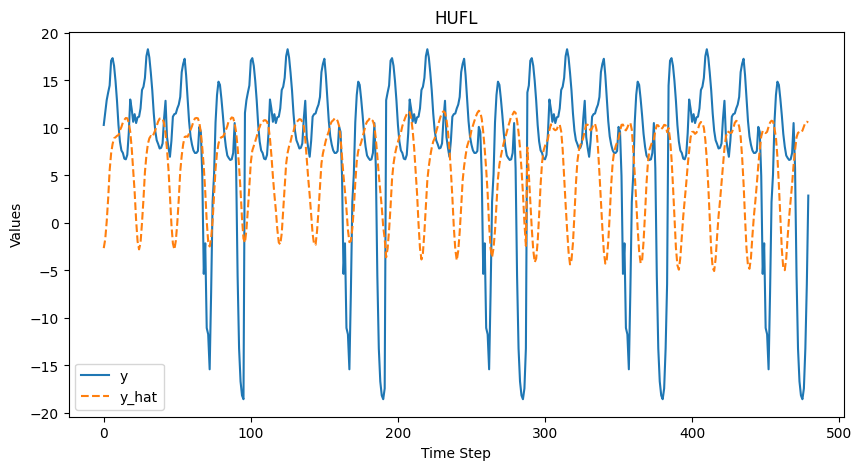

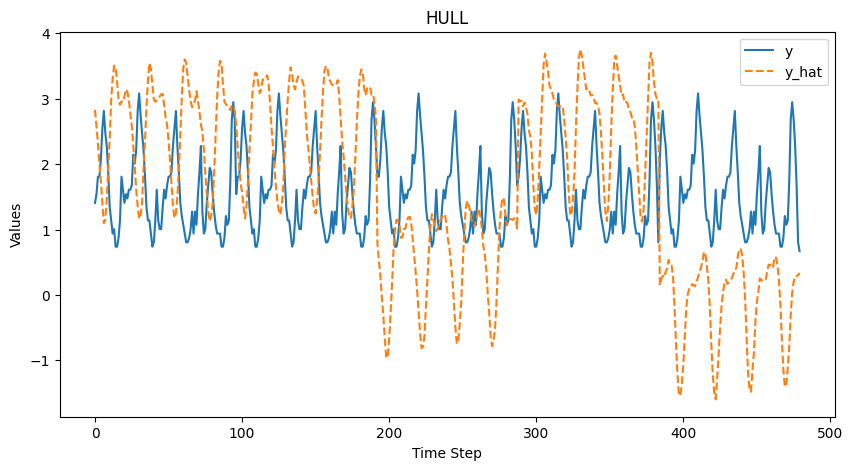

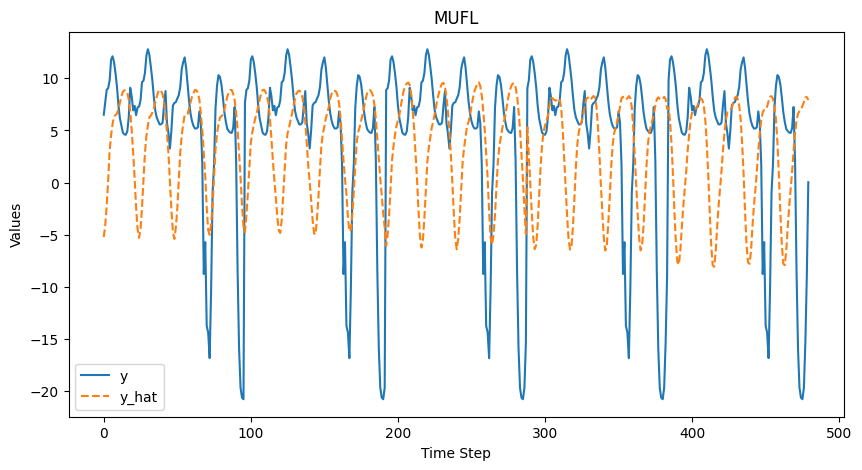

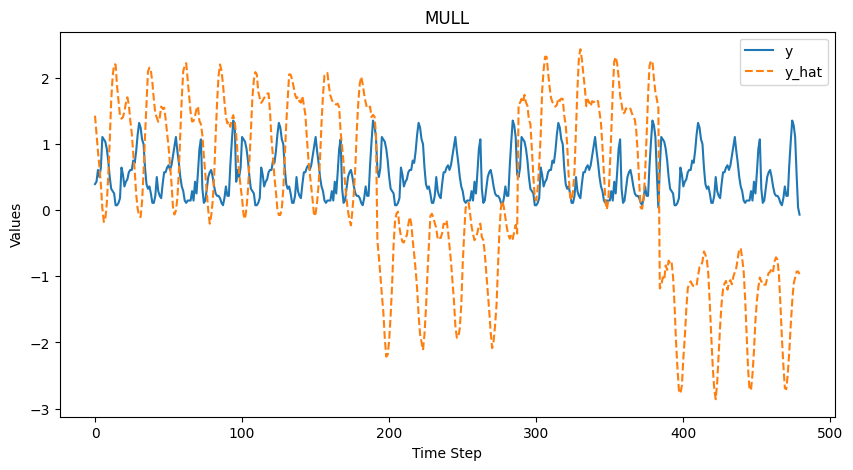

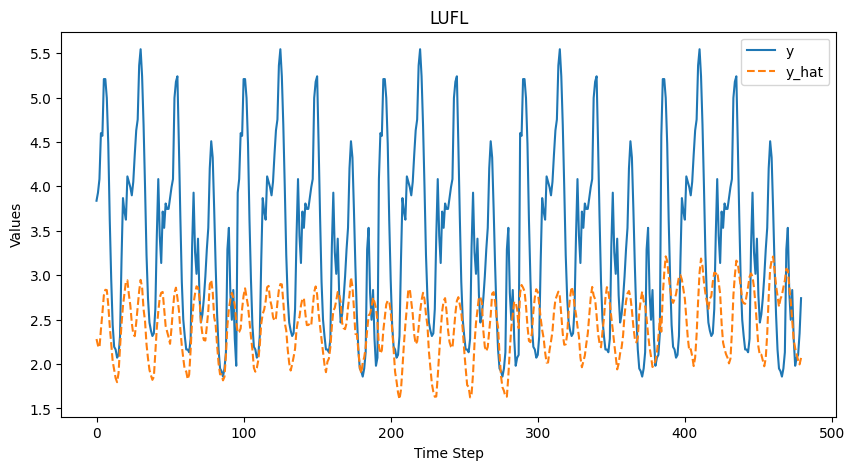

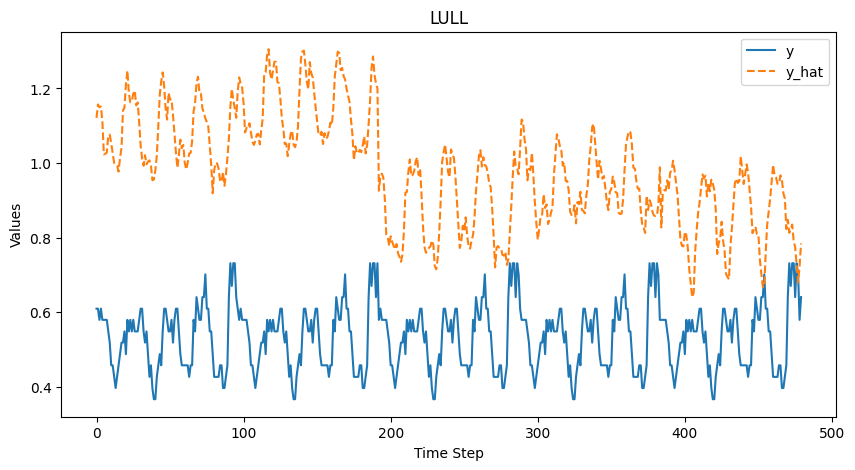

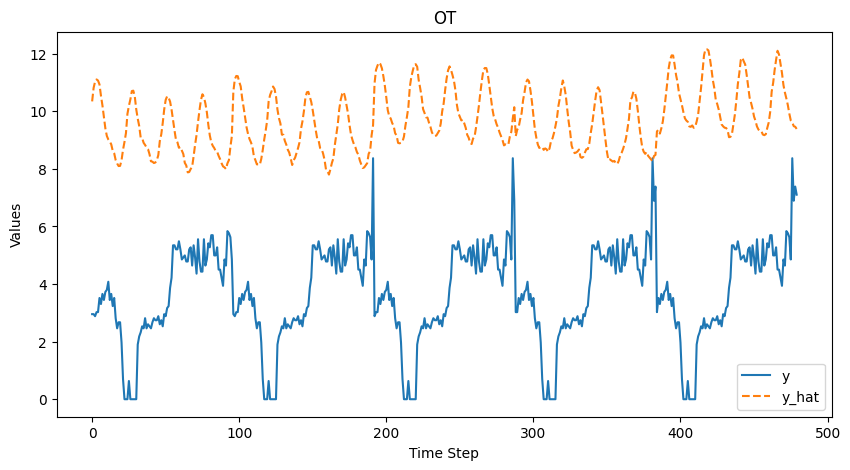

In [ ]:
RNN_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                             yhat=RNN_multi2multi_manager.predict(multi2multi_loader.test_loader),
                             feature_names=multi2multi_loader.out_features,
                             save_dir=os.path.join(plot_dir, sub_dir),
                             save_plots=True,
                             num_elements=ele)

### **LSTM**

In [ ]:
LSTM_multi2multi = LSTM(input_size=multi2multi_loader.in_variable,
                        hidden_size=hidden_size,
                        output_size=multi2multi_loader.out_variable,
                        ahead=label_size,
                        num_layers=num_layers)
LSTM_multi2multi_manager = ModelManager(model=LSTM_multi2multi,
                                        train_loader=multi2multi_loader.train_loader,
                                        val_loader=multi2multi_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)
LSTM_multi2multi_manager.train(num_epochs=num_epochs,
                              save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

Model saved to weights\multi2multi\best-LSTM.pth
Epoch [1/1000000], time: 50s, loss: 3.6222, val_loss: 3.2154
Epoch [2/1000000], time: 49s, loss: 2.7683, val_loss: 3.6213
Epoch [3/1000000], time: 49s, loss: 2.7491, val_loss: 3.6428
Epoch [4/1000000], time: 49s, loss: 2.5998, val_loss: 3.5903
Epoch [5/1000000], time: 49s, loss: 2.3548, val_loss: 3.5180
Epoch [6/1000000], time: 49s, loss: 2.2306, val_loss: 3.2928
Model saved to weights\multi2multi\best-LSTM.pth
Epoch [7/1000000], time: 49s, loss: 2.1372, val_loss: 3.0611
Model saved to weights\multi2multi\best-LSTM.pth
Epoch [8/1000000], time: 49s, loss: 2.0534, val_loss: 2.9348
Epoch [9/1000000], time: 49s, loss: 1.9733, val_loss: 3.0665
Epoch [10/1000000], time: 49s, loss: 1.9071, val_loss: 2.9969
Epoch [11/1000000], time: 49s, loss: 1.8782, val_loss: 3.0535
Model saved to weights\multi2multi\best-LSTM.pth
Epoch [12/1000000], time: 49s, loss: 1.7774, val_loss: 2.9159
Model saved to weights\multi2multi\best-LSTM.pth
Epoch [13/1000000], 

{'Name': 'LSTM', 'Type': 'multi2multi', 'MAE': 2.2900558206770154}

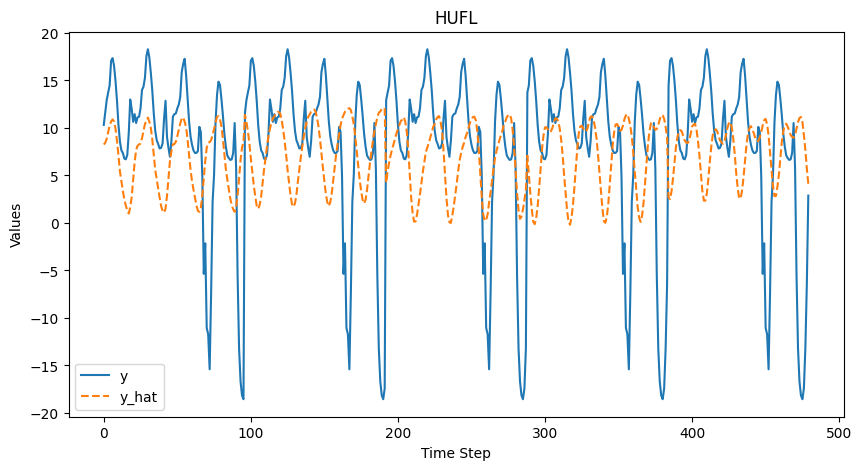

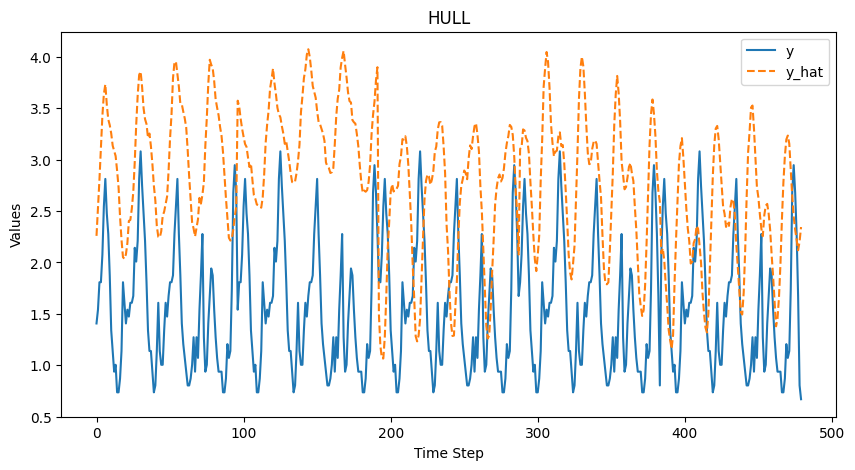

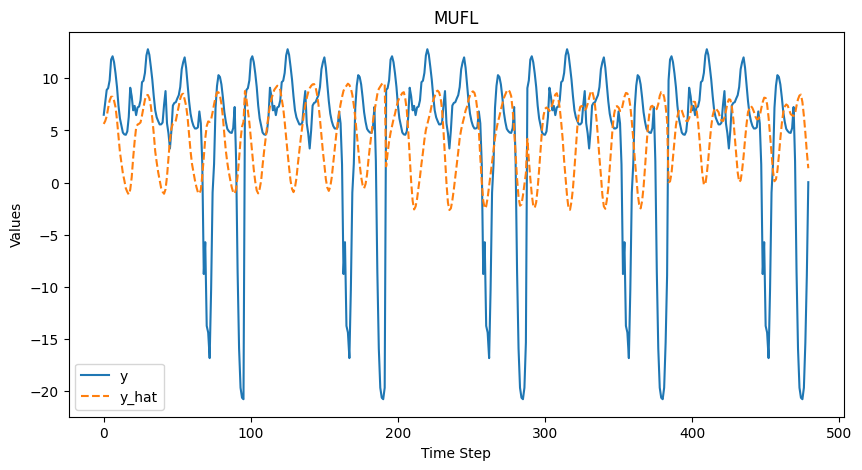

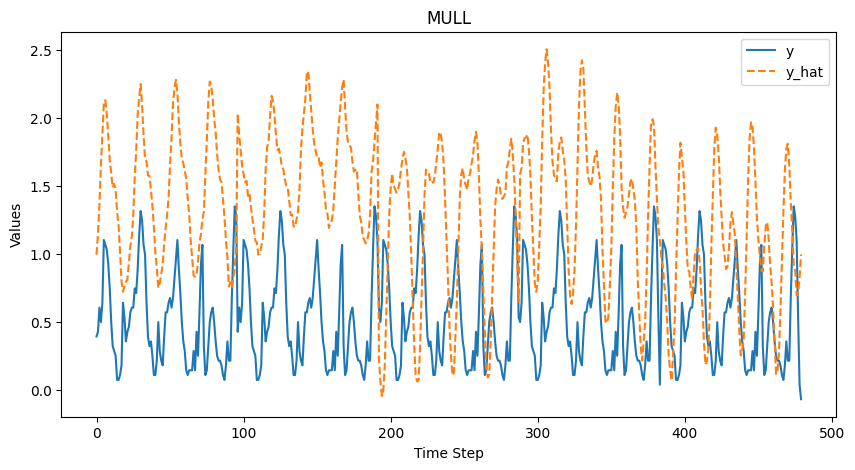

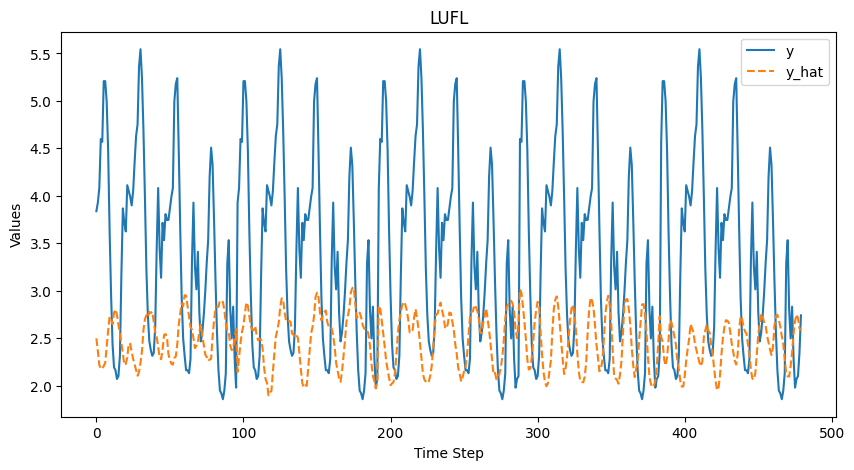

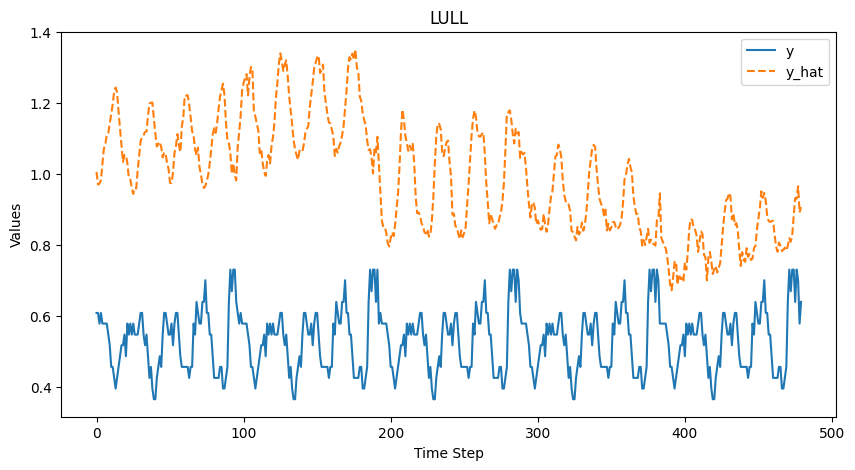

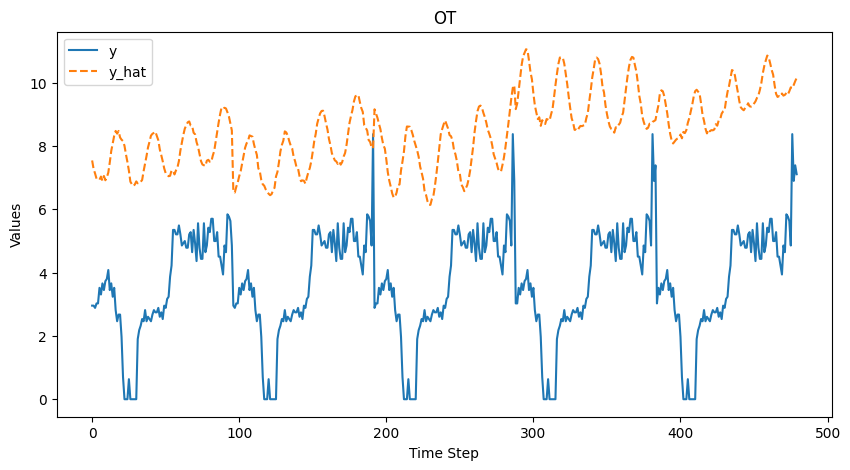

In [ ]:
LSTM_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                              yhat=LSTM_multi2multi_manager.predict(multi2multi_loader.test_loader),
                              feature_names=multi2multi_loader.out_features,
                              save_dir=os.path.join(plot_dir, sub_dir),
                              save_plots=True,
                              num_elements=ele)

### **BiLSTM**

In [ ]:
BiLSTM_multi2multi = BiLSTM(input_size=multi2multi_loader.in_variable,
                            hidden_size=hidden_size,
                            output_size=multi2multi_loader.out_variable,
                            ahead=label_size,
                            num_layers=num_layers)
BiLSTM_multi2multi_manager = ModelManager(model=BiLSTM_multi2multi,
                                          train_loader=multi2multi_loader.train_loader,
                                          val_loader=multi2multi_loader.val_loader,
                                          lr=learning_rate,
                                          patience=patience)
BiLSTM_multi2multi_manager.train(num_epochs=num_epochs,
                                 save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

Model saved to weights\multi2multi\best-BiLSTM.pth
Epoch [1/1000000], time: 101s, loss: 3.3011, val_loss: 3.5839
Model saved to weights\multi2multi\best-BiLSTM.pth
Epoch [2/1000000], time: 101s, loss: 2.5628, val_loss: 3.5039
Model saved to weights\multi2multi\best-BiLSTM.pth
Epoch [3/1000000], time: 100s, loss: 2.2567, val_loss: 3.1579
Model saved to weights\multi2multi\best-BiLSTM.pth
Epoch [4/1000000], time: 101s, loss: 2.0776, val_loss: 3.0375
Model saved to weights\multi2multi\best-BiLSTM.pth
Epoch [5/1000000], time: 100s, loss: 1.9766, val_loss: 2.9258
Model saved to weights\multi2multi\best-BiLSTM.pth
Epoch [6/1000000], time: 101s, loss: 1.9059, val_loss: 2.7695
Model saved to weights\multi2multi\best-BiLSTM.pth
Epoch [7/1000000], time: 100s, loss: 1.8451, val_loss: 2.7503
Model saved to weights\multi2multi\best-BiLSTM.pth
Epoch [8/1000000], time: 101s, loss: 1.7898, val_loss: 2.7456
Model saved to weights\multi2multi\best-BiLSTM.pth
Epoch [9/1000000], time: 100s, loss: 1.7264, 

{'Name': 'BiLSTM', 'Type': 'multi2multi', 'MAE': 2.5619537141588}

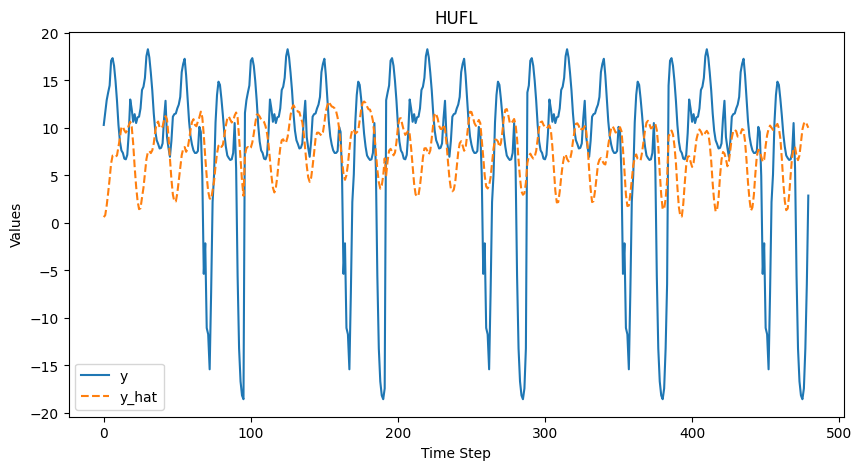

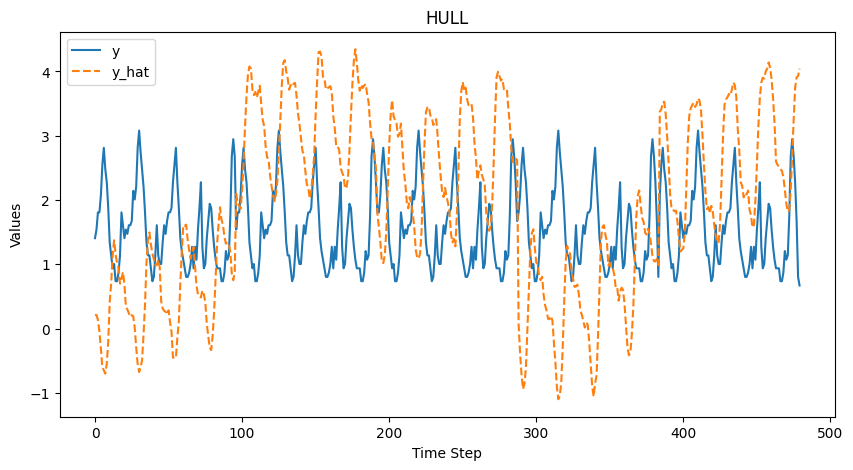

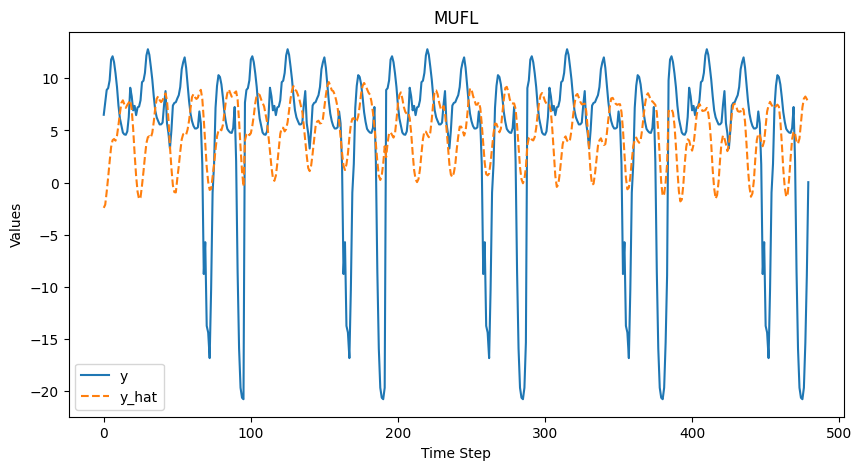

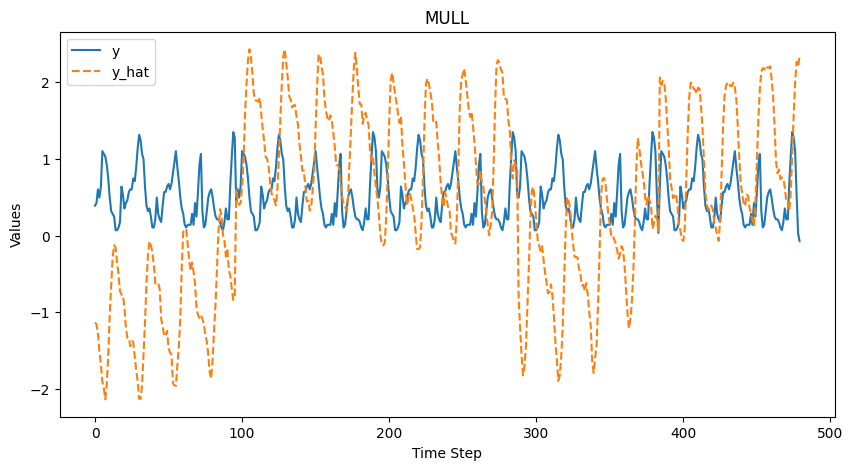

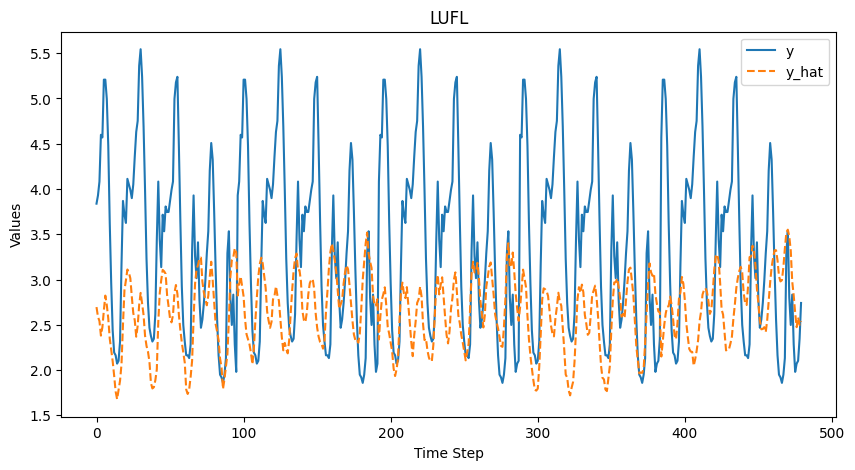

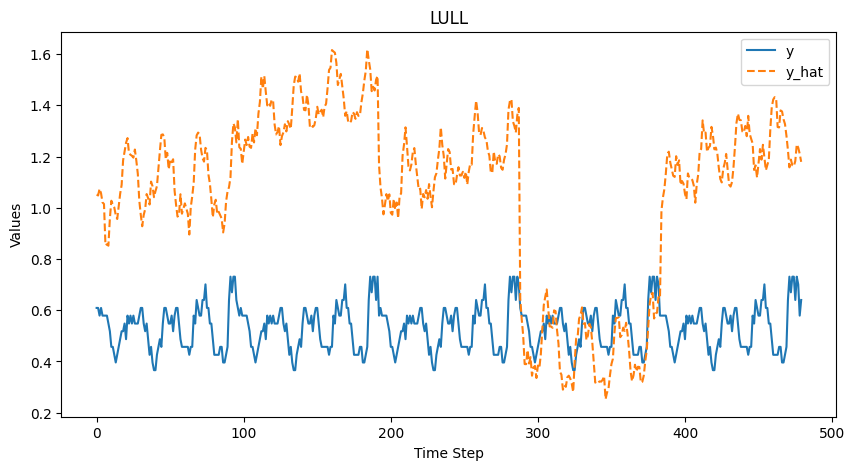

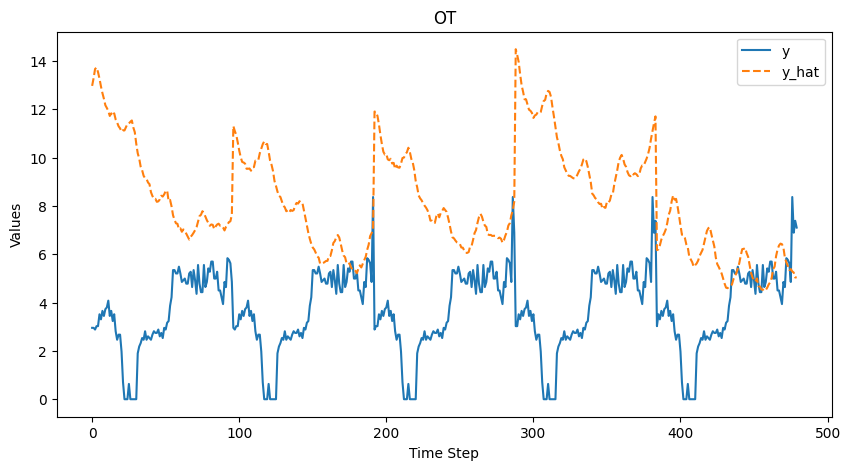

In [ ]:
BiLSTM_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                                yhat=BiLSTM_multi2multi_manager.predict(multi2multi_loader.test_loader),
                                feature_names=multi2multi_loader.out_features,
                                save_dir=os.path.join(plot_dir, sub_dir),
                                save_plots=True,
                                num_elements=ele)

### **XGBoost**

In [ ]:
XGBoost_multi2multi = XGBRegressor(**xgboost_config)
XGBoost_multi2multi_manager = MachineLearningModelManager(model=XGBoost_multi2multi,
                                                          xtrain=multi2multi_loader.X_train,
                                                          ytrain=multi2multi_loader.y_train,
                                                          xval=multi2multi_loader.X_val,
                                                          yval=multi2multi_loader.y_val)
XGBoost_multi2multi_manager.train(save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": XGBoost_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_multi2multi_manager.evaluate(x=multi2multi_loader.X_test, y=multi2multi_loader.y_test)
})
results[-1]

[0]	validation_0-mae:3.90950
[1]	validation_0-mae:3.61946
[2]	validation_0-mae:3.38305
[3]	validation_0-mae:3.19688
[4]	validation_0-mae:3.03972
[5]	validation_0-mae:2.90963
[6]	validation_0-mae:2.80516
[7]	validation_0-mae:2.71748
[8]	validation_0-mae:2.64182
[9]	validation_0-mae:2.57834
[10]	validation_0-mae:2.52591
[11]	validation_0-mae:2.47779
[12]	validation_0-mae:2.43841
[13]	validation_0-mae:2.40225
[14]	validation_0-mae:2.37335
[15]	validation_0-mae:2.34768
[16]	validation_0-mae:2.32790
[17]	validation_0-mae:2.31115
[18]	validation_0-mae:2.29722
[19]	validation_0-mae:2.28611
[20]	validation_0-mae:2.27928
[21]	validation_0-mae:2.27775
[22]	validation_0-mae:2.27729
[23]	validation_0-mae:2.27361
[24]	validation_0-mae:2.26943
[25]	validation_0-mae:2.26104
[26]	validation_0-mae:2.25268
[27]	validation_0-mae:2.24398
[28]	validation_0-mae:2.23844
[29]	validation_0-mae:2.23733
[30]	validation_0-mae:2.23390
[31]	validation_0-mae:2.23204
[32]	validation_0-mae:2.22914
[33]	validation_0-ma

{'Name': 'XGBRegressor', 'Type': 'multi2multi', 'MAE': 2.0211456609478002}

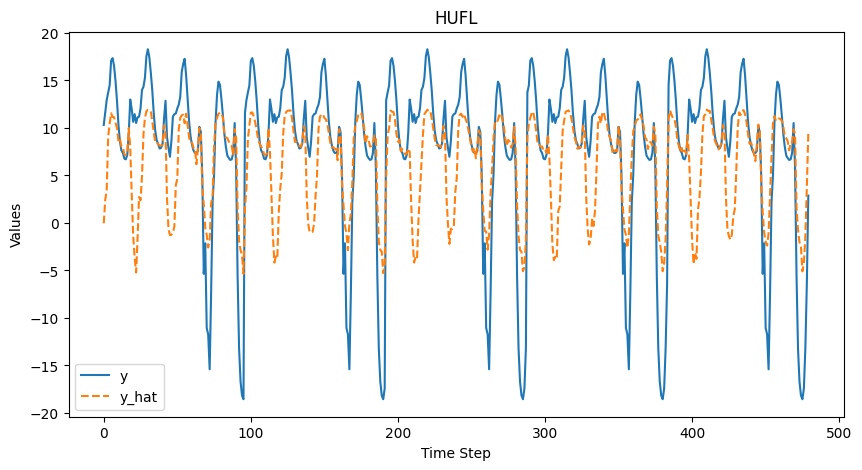

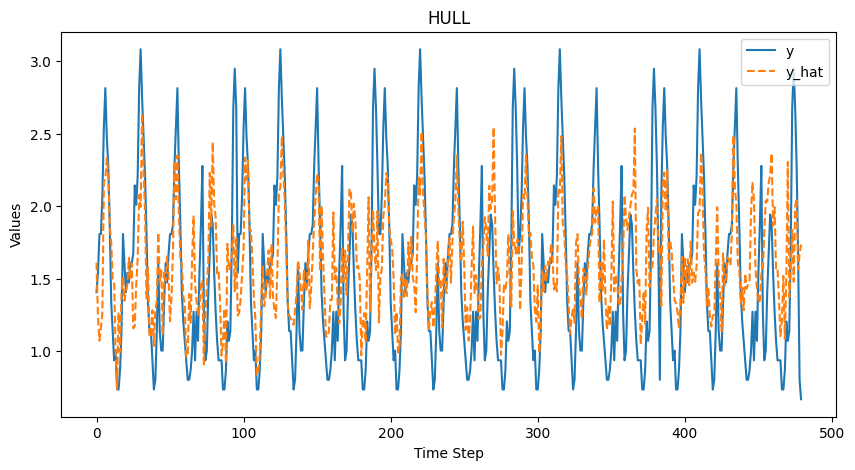

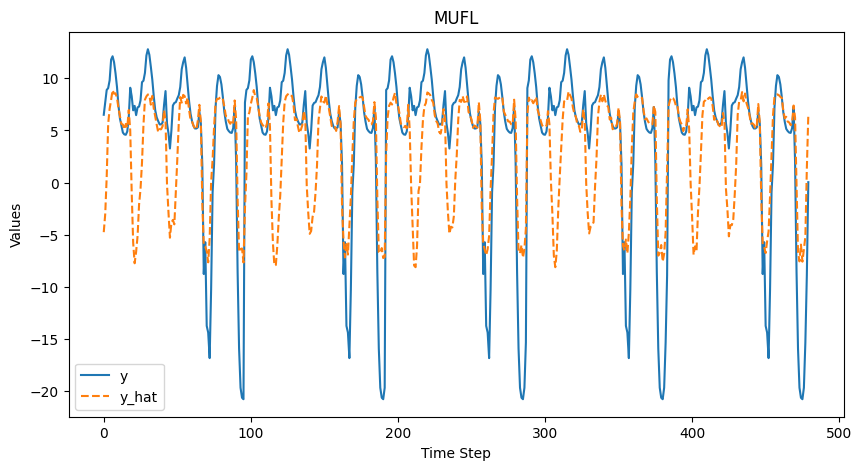

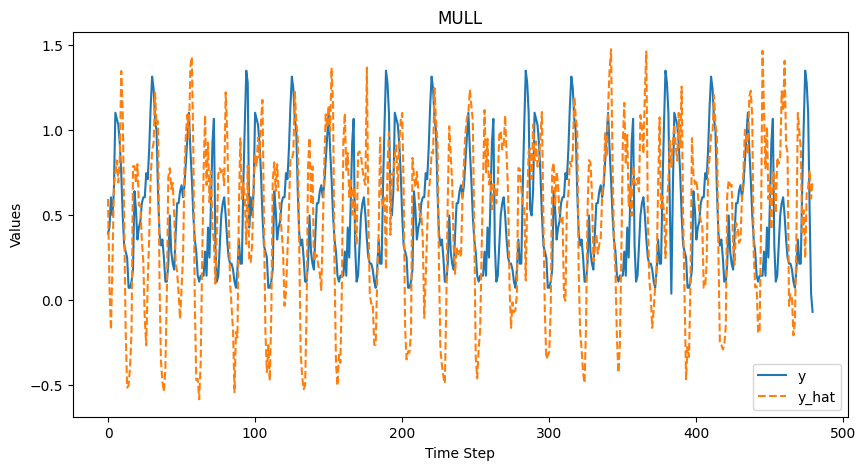

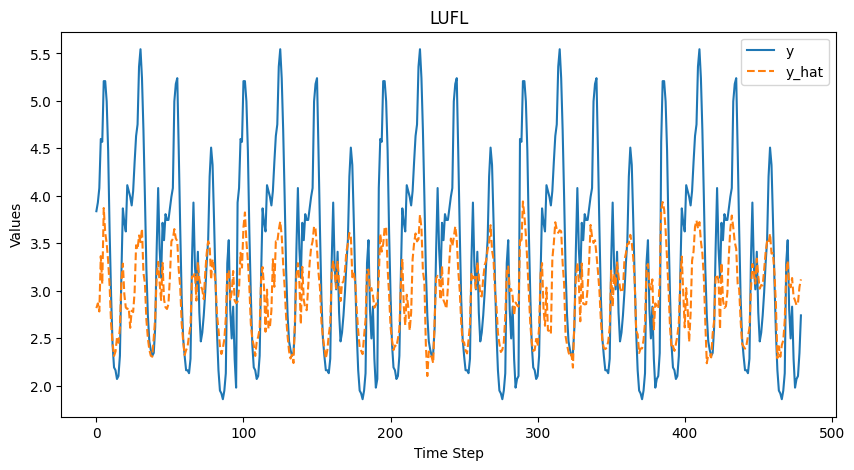

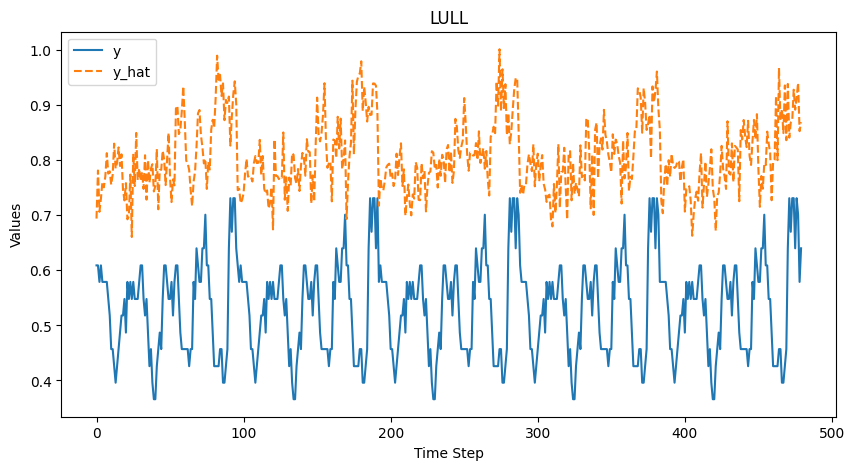

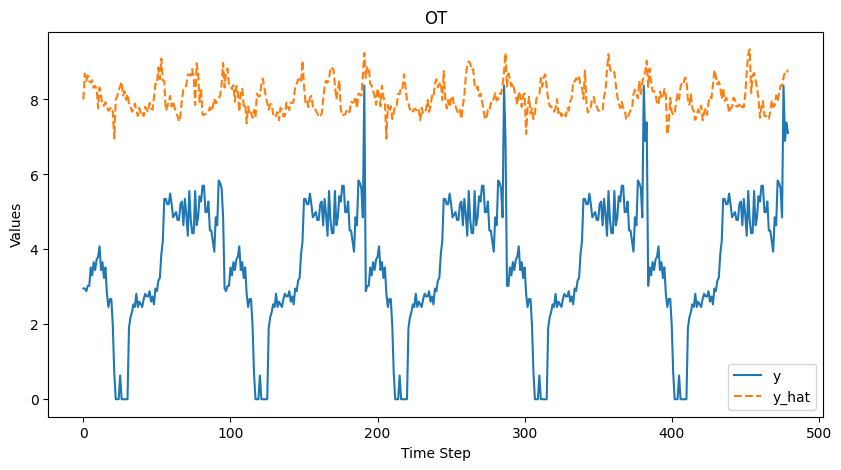

In [ ]:
XGBoost_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                                 yhat=XGBoost_multi2multi_manager.predict(multi2multi_loader.X_test),
                                 feature_names=multi2multi_loader.out_features,
                                 save_dir=os.path.join(plot_dir, sub_dir),
                                 save_plots=True,
                                 num_elements=ele)

# **Multivariate-to-Univartiate**

In [ ]:
features_type='MS'
sub_dir = 'multi2uni'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2uni_loader = TimeSeriesDataLoader(file_path,
                                        input_size=input_size,
                                        label_size=label_size,
                                        offset=offset,
                                        train_size=train_size,
                                        val_size=val_size,
                                        target_name=target_name,
                                        features_type=features_type,
                                        date_column=date_column)

Offset will be change from 1 to 96
self.X_train.shape = (11762, 336, 7)
self.y_train.shape = (11762, 96, 1)
self.X_val.shape = (1309, 336, 7)
self.y_val.shape = (1309, 96, 1)
self.X_test.shape = (2861, 336, 7)
self.y_test.shape = (2861, 96, 1)


### **MLP**

In [ ]:
MLP_multi2uni = MLP(input_size=multi2uni_loader.in_variable*input_size,
                    hidden_size=hidden_size,
                    output_size=multi2uni_loader.out_variable,
                    ahead=label_size)
MLP_multi2uni_manager = ModelManager(model=MLP_multi2uni,
                                     train_loader=multi2uni_loader.train_loader,
                                     val_loader=multi2uni_loader.val_loader,
                                     lr=learning_rate,
                                     patience=patience)
MLP_multi2uni_manager.train(num_epochs=num_epochs,
                            save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": MLP_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": MLP_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

Model saved to weights\multi2uni\best-MLP.pth
Epoch [1/1000000], time: 0s, loss: 3.6590, val_loss: 2.4698
Epoch [2/1000000], time: 0s, loss: 2.8667, val_loss: 2.5052
Epoch [3/1000000], time: 0s, loss: 2.8288, val_loss: 2.6501
Model saved to weights\multi2uni\best-MLP.pth
Epoch [4/1000000], time: 0s, loss: 2.8099, val_loss: 2.4531
Model saved to weights\multi2uni\best-MLP.pth
Epoch [5/1000000], time: 0s, loss: 2.7538, val_loss: 2.3900
Model saved to weights\multi2uni\best-MLP.pth
Epoch [6/1000000], time: 0s, loss: 2.7593, val_loss: 2.3347
Epoch [7/1000000], time: 0s, loss: 2.7281, val_loss: 2.4575
Epoch [8/1000000], time: 0s, loss: 2.7109, val_loss: 2.3844
Epoch [9/1000000], time: 0s, loss: 2.7087, val_loss: 2.4630
Epoch [10/1000000], time: 0s, loss: 2.6996, val_loss: 2.4503
Epoch [11/1000000], time: 0s, loss: 2.6819, val_loss: 2.3694
Epoch [12/1000000], time: 0s, loss: 2.6729, val_loss: 2.3902
Epoch [13/1000000], time: 0s, loss: 2.6710, val_loss: 2.4181
Epoch [14/1000000], time: 0s, lo

{'Name': 'MLP', 'Type': 'multi2uni', 'MAE': 3.084312645594279}

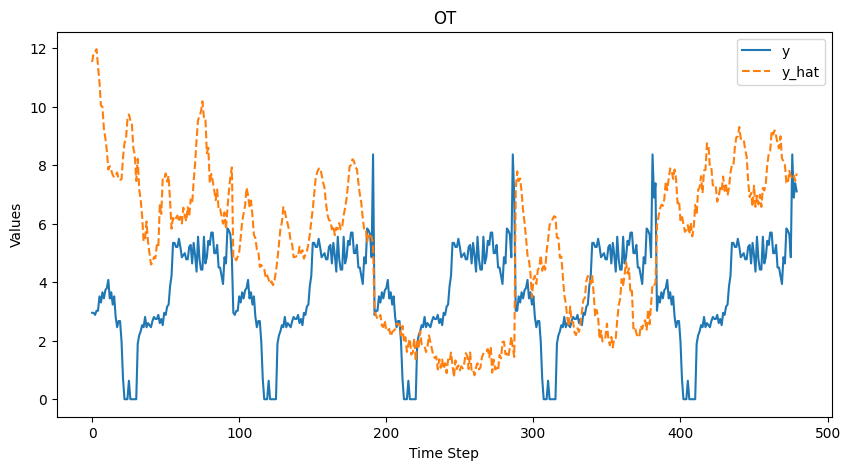

In [ ]:
MLP_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                           yhat=MLP_multi2uni_manager.predict(multi2uni_loader.test_loader),
                           feature_names=multi2uni_loader.out_features,
                           save_dir=os.path.join(plot_dir, sub_dir),
                           save_plots=True,
                           num_elements=ele)

### **RNN**

In [ ]:
RNN_multi2uni = RNN(input_size=multi2uni_loader.in_variable,
                    hidden_size=hidden_size,
                    output_size=multi2uni_loader.out_variable,
                    ahead=label_size,
                    num_layers=num_layers)
RNN_multi2uni_manager = ModelManager(model=RNN_multi2uni,
                                     train_loader=multi2uni_loader.train_loader,
                                     val_loader=multi2uni_loader.val_loader,
                                     lr=learning_rate,
                                     patience=patience)
RNN_multi2uni_manager.train(num_epochs=num_epochs,
                            save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": RNN_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

Model saved to weights\multi2uni\best-RNN.pth
Epoch [1/1000000], time: 12s, loss: 10.3043, val_loss: 7.7479
Epoch [2/1000000], time: 12s, loss: 6.3072, val_loss: 11.0399
Model saved to weights\multi2uni\best-RNN.pth
Epoch [3/1000000], time: 12s, loss: 5.9718, val_loss: 6.7918
Model saved to weights\multi2uni\best-RNN.pth
Epoch [4/1000000], time: 12s, loss: 4.5041, val_loss: 6.5277
Model saved to weights\multi2uni\best-RNN.pth
Epoch [5/1000000], time: 12s, loss: 4.2622, val_loss: 5.8286
Epoch [6/1000000], time: 12s, loss: 3.8643, val_loss: 5.8501
Epoch [7/1000000], time: 12s, loss: 3.5175, val_loss: 5.9920
Epoch [8/1000000], time: 12s, loss: 3.5361, val_loss: 6.1871
Epoch [9/1000000], time: 12s, loss: 3.3246, val_loss: 6.5738
Epoch [10/1000000], time: 12s, loss: 3.3235, val_loss: 6.0270
Model saved to weights\multi2uni\best-RNN.pth
Epoch [11/1000000], time: 12s, loss: 3.2431, val_loss: 5.6539
Epoch [12/1000000], time: 12s, loss: 3.3397, val_loss: 5.8366
Epoch [13/1000000], time: 12s, lo

{'Name': 'RNN', 'Type': 'multi2uni', 'MAE': 2.6288574430677625}

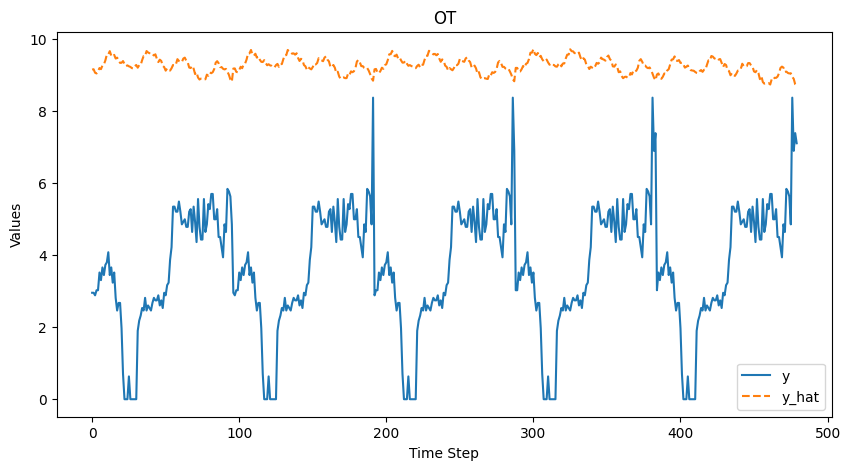

In [ ]:
RNN_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                           yhat=RNN_multi2uni_manager.predict(multi2uni_loader.test_loader),
                           feature_names=multi2uni_loader.out_features,
                           save_dir=os.path.join(plot_dir, sub_dir),
                           save_plots=True,
                           num_elements=ele)

### **LSTM**

In [ ]:
LSTM_multi2uni = LSTM(input_size=multi2uni_loader.in_variable,
                      hidden_size=hidden_size,
                      output_size=multi2uni_loader.out_variable,
                      ahead=label_size,
                      num_layers=num_layers)
LSTM_multi2uni_manager = ModelManager(model=LSTM_multi2uni,
                                     train_loader=multi2uni_loader.train_loader,
                                     val_loader=multi2uni_loader.val_loader,
                                     lr=learning_rate,
                                     patience=patience)
LSTM_multi2uni_manager.train(num_epochs=num_epochs,
                            save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

Model saved to weights\multi2uni\best-LSTM.pth
Epoch [1/1000000], time: 46s, loss: 10.0070, val_loss: 8.3381
Epoch [2/1000000], time: 46s, loss: 6.2405, val_loss: 11.2806
Epoch [3/1000000], time: 45s, loss: 6.1128, val_loss: 11.5587
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [4/1000000], time: 46s, loss: 4.6260, val_loss: 4.5367
Epoch [5/1000000], time: 45s, loss: 3.6095, val_loss: 4.6829
Epoch [6/1000000], time: 45s, loss: 3.2250, val_loss: 5.2788
Epoch [7/1000000], time: 45s, loss: 2.8903, val_loss: 5.4833
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [8/1000000], time: 46s, loss: 2.7042, val_loss: 4.5288
Epoch [9/1000000], time: 45s, loss: 2.6894, val_loss: 5.6343
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [10/1000000], time: 45s, loss: 2.4250, val_loss: 2.9342
Model saved to weights\multi2uni\best-LSTM.pth
Epoch [11/1000000], time: 45s, loss: 2.3697, val_loss: 2.3196
Epoch [12/1000000], time: 45s, loss: 2.3757, val_loss: 2.8597
Epoch [13/1000000], time: 4

{'Name': 'LSTM', 'Type': 'multi2uni', 'MAE': 3.1846184624565974}

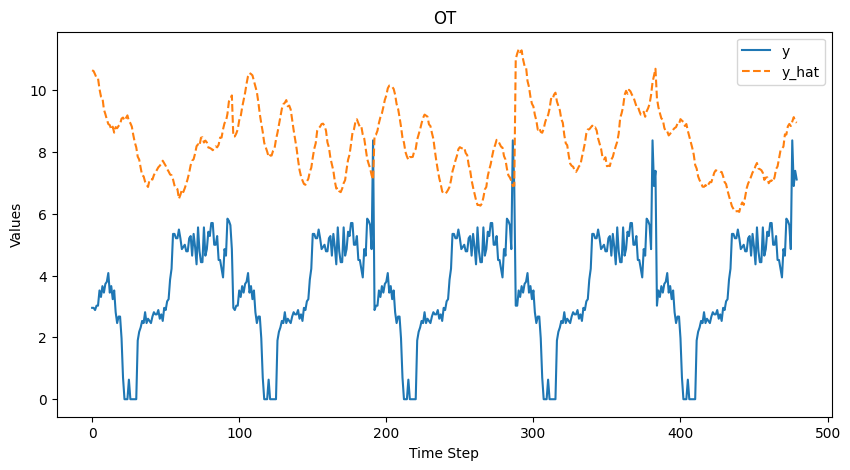

In [ ]:
LSTM_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                            yhat=LSTM_multi2uni_manager.predict(multi2uni_loader.test_loader),
                            feature_names=multi2uni_loader.out_features,
                            save_dir=os.path.join(plot_dir, sub_dir),
                            save_plots=True,
                            num_elements=ele)

### **BiLSTM**

In [ ]:
BiLSTM_multi2uni = BiLSTM(input_size=multi2uni_loader.in_variable,
                          hidden_size=hidden_size,
                          output_size=multi2uni_loader.out_variable,
                          ahead=label_size,
                          num_layers=num_layers)
BiLSTM_multi2uni_manager = ModelManager(model=BiLSTM_multi2uni,
                                        train_loader=multi2uni_loader.train_loader,
                                        val_loader=multi2uni_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)
BiLSTM_multi2uni_manager.train(num_epochs=num_epochs,
                               save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [1/1000000], time: 99s, loss: 8.4838, val_loss: 11.3891
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [2/1000000], time: 99s, loss: 4.8361, val_loss: 5.7876
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [3/1000000], time: 99s, loss: 3.6144, val_loss: 5.7612
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [4/1000000], time: 99s, loss: 3.0502, val_loss: 5.7095
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [5/1000000], time: 99s, loss: 2.7928, val_loss: 4.9021
Epoch [6/1000000], time: 99s, loss: 2.6005, val_loss: 5.0521
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [7/1000000], time: 100s, loss: 2.5235, val_loss: 4.4274
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [8/1000000], time: 100s, loss: 2.4205, val_loss: 4.1710
Model saved to weights\multi2uni\best-BiLSTM.pth
Epoch [9/1000000], time: 99s, loss: 2.4437, val_loss: 3.8425
Epoch [10/1000000], time: 99s, loss: 2.3599, val_loss: 3

{'Name': 'BiLSTM', 'Type': 'multi2uni', 'MAE': 2.7440033117930094}

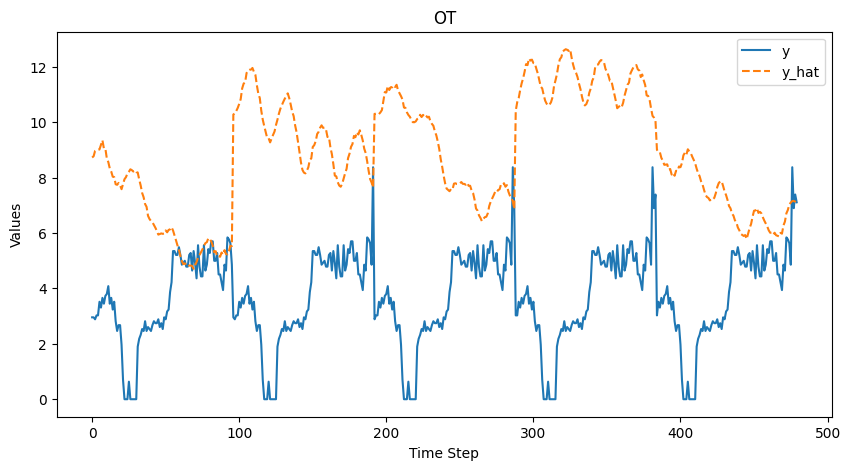

In [ ]:
BiLSTM_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                              yhat=BiLSTM_multi2uni_manager.predict(multi2uni_loader.test_loader),
                              feature_names=multi2uni_loader.out_features,
                              save_dir=os.path.join(plot_dir, sub_dir),
                              save_plots=True,
                              num_elements=ele)

### **XGBoost**

In [ ]:
XGBoost_multi2uni = XGBRegressor(**xgboost_config)
XGBoost_multi2uni_manager = MachineLearningModelManager(model=XGBoost_multi2uni,
                                                        xtrain=multi2uni_loader.X_train,
                                                        ytrain=multi2uni_loader.y_train,
                                                        xval=multi2uni_loader.X_val,
                                                        yval=multi2uni_loader.y_val)
XGBoost_multi2uni_manager.train(save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": XGBoost_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_multi2uni_manager.evaluate(x=multi2uni_loader.X_test, y=multi2uni_loader.y_test)
})
results[-1]

[0]	validation_0-mae:2.54231
[1]	validation_0-mae:2.15630
[2]	validation_0-mae:1.95168
[3]	validation_0-mae:1.89940
[4]	validation_0-mae:1.94974
[5]	validation_0-mae:2.08648
[6]	validation_0-mae:2.28230
[7]	validation_0-mae:2.51124
[8]	validation_0-mae:2.74808
[9]	validation_0-mae:2.98578
[10]	validation_0-mae:3.21917
[11]	validation_0-mae:3.42699
[12]	validation_0-mae:3.61834
[13]	validation_0-mae:3.78951
[14]	validation_0-mae:3.95005
[15]	validation_0-mae:4.09462
[16]	validation_0-mae:4.23300
[17]	validation_0-mae:4.35373
[18]	validation_0-mae:4.45131
[19]	validation_0-mae:4.53568
[20]	validation_0-mae:4.60017
[21]	validation_0-mae:4.65620
[22]	validation_0-mae:4.69127
[23]	validation_0-mae:4.70401
Model saved to weights\multi2uni\best-XGBRegressor.pkl


{'Name': 'XGBRegressor', 'Type': 'multi2uni', 'MAE': 5.014658672493991}

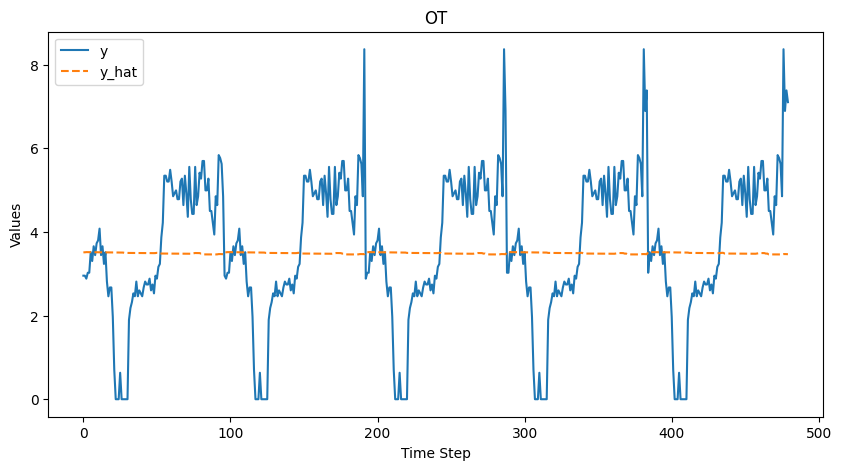

In [ ]:
XGBoost_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                               yhat=XGBoost_multi2uni_manager.predict(multi2uni_loader.X_test),
                               feature_names=multi2uni_loader.out_features,
                               save_dir=os.path.join(plot_dir, sub_dir),
                               save_plots=True,
                               num_elements=ele)

# **Univariate-to-Univartiate**

In [ ]:
features_type='S'
sub_dir = 'uni2uni'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
uni2uni_loader = TimeSeriesDataLoader(file_path,
                                      input_size=input_size,
                                      label_size=label_size,
                                      offset=offset,
                                      train_size=train_size,
                                      val_size=val_size,
                                      target_name=target_name,
                                      features_type=features_type,
                                      date_column=date_column)

Offset will be change from 1 to 96
self.X_train.shape = (11762, 336, 1)
self.y_train.shape = (11762, 96, 1)
self.X_val.shape = (1309, 336, 1)
self.y_val.shape = (1309, 96, 1)
self.X_test.shape = (2861, 336, 1)
self.y_test.shape = (2861, 96, 1)


### **MLP**

In [ ]:
MLP_uni2uni = MLP(input_size=uni2uni_loader.in_variable*input_size,
                  hidden_size=hidden_size,
                  output_size=uni2uni_loader.out_variable,
                  ahead=label_size)
MLP_uni2uni_manager = ModelManager(model=MLP_uni2uni,
                                   train_loader=uni2uni_loader.train_loader,
                                   val_loader=uni2uni_loader.val_loader,
                                   lr=learning_rate,
                                   patience=patience)
MLP_uni2uni_manager.train(num_epochs=num_epochs,
                          save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": MLP_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": MLP_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

Model saved to weights\uni2uni\best-MLP.pth
Epoch [1/1000000], time: 0s, loss: 4.0400, val_loss: 2.3057
Epoch [2/1000000], time: 0s, loss: 3.0769, val_loss: 2.3227
Model saved to weights\uni2uni\best-MLP.pth
Epoch [3/1000000], time: 0s, loss: 3.0615, val_loss: 2.2921
Epoch [4/1000000], time: 0s, loss: 3.0367, val_loss: 2.3198
Epoch [5/1000000], time: 0s, loss: 3.0364, val_loss: 2.3438
Epoch [6/1000000], time: 0s, loss: 3.0367, val_loss: 2.3045
Epoch [7/1000000], time: 0s, loss: 2.9928, val_loss: 2.3039
Epoch [8/1000000], time: 0s, loss: 2.9893, val_loss: 2.3233
Epoch [9/1000000], time: 0s, loss: 2.9864, val_loss: 2.3368
Epoch [10/1000000], time: 0s, loss: 2.9712, val_loss: 2.3269
Epoch [11/1000000], time: 0s, loss: 2.9837, val_loss: 2.3602
Epoch [12/1000000], time: 0s, loss: 2.9656, val_loss: 2.3495
Epoch [13/1000000], time: 0s, loss: 2.9608, val_loss: 2.3208
Epoch [14/1000000], time: 0s, loss: 2.9511, val_loss: 2.3387
Epoch [15/1000000], time: 0s, loss: 2.9444, val_loss: 2.3170
Epoch 

{'Name': 'MLP', 'Type': 'uni2uni', 'MAE': 2.2932867844899496}

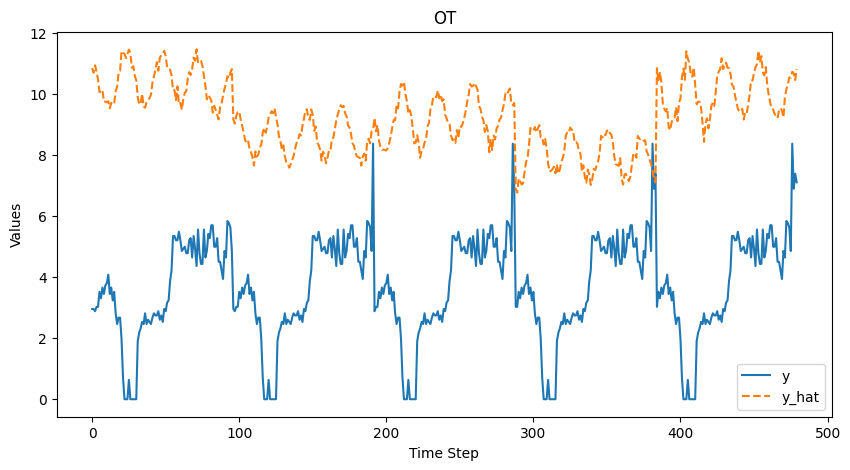

In [ ]:
MLP_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                         yhat=MLP_uni2uni_manager.predict(uni2uni_loader.test_loader),
                         feature_names=uni2uni_loader.out_features,
                         save_dir=os.path.join(plot_dir, sub_dir),
                         save_plots=True,
                         num_elements=ele)

### **RNN**

In [ ]:
RNN_uni2uni = RNN(input_size=uni2uni_loader.in_variable,
                  hidden_size=hidden_size,
                  output_size=uni2uni_loader.out_variable,
                  ahead=label_size,
                  num_layers=num_layers)
RNN_uni2uni_manager = ModelManager(model=RNN_uni2uni,
                                   train_loader=uni2uni_loader.train_loader,
                                   val_loader=uni2uni_loader.val_loader,
                                   lr=learning_rate,
                                   patience=patience)
RNN_uni2uni_manager.train(num_epochs=num_epochs,
                          save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": RNN_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

Model saved to weights\uni2uni\best-RNN.pth
Epoch [1/1000000], time: 14s, loss: 10.2070, val_loss: 7.8389
Epoch [2/1000000], time: 14s, loss: 6.2960, val_loss: 11.0829
Model saved to weights\uni2uni\best-RNN.pth
Epoch [3/1000000], time: 14s, loss: 5.4109, val_loss: 4.8531
Epoch [4/1000000], time: 14s, loss: 4.3341, val_loss: 6.5293
Epoch [5/1000000], time: 14s, loss: 3.9893, val_loss: 6.1969
Epoch [6/1000000], time: 14s, loss: 3.7598, val_loss: 6.1335
Epoch [7/1000000], time: 14s, loss: 3.5915, val_loss: 6.3988
Epoch [8/1000000], time: 14s, loss: 3.5217, val_loss: 6.5649
Epoch [9/1000000], time: 14s, loss: 3.4942, val_loss: 6.2713
Epoch [10/1000000], time: 14s, loss: 3.3915, val_loss: 6.5625
Epoch [11/1000000], time: 14s, loss: 4.0709, val_loss: 6.7960
Epoch [12/1000000], time: 14s, loss: 4.1741, val_loss: 5.9032
Epoch [13/1000000], time: 13s, loss: 3.8076, val_loss: 6.4605
Epoch [14/1000000], time: 13s, loss: 3.5994, val_loss: 6.3087
Epoch [15/1000000], time: 13s, loss: 3.4628, val_lo

{'Name': 'RNN', 'Type': 'uni2uni', 'MAE': 2.8022586080763077}

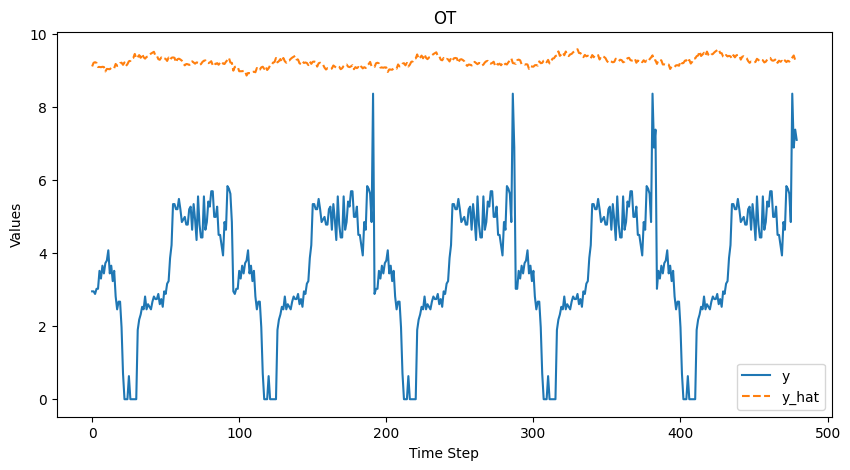

In [ ]:
RNN_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                         yhat=RNN_uni2uni_manager.predict(uni2uni_loader.test_loader),
                         feature_names=uni2uni_loader.out_features,
                         save_dir=os.path.join(plot_dir, sub_dir),
                         save_plots=True,
                         num_elements=ele)

### **LSTM**

In [ ]:
LSTM_uni2uni = LSTM(input_size=uni2uni_loader.in_variable,
                    hidden_size=hidden_size,
                    output_size=uni2uni_loader.out_variable,
                    ahead=label_size,
                    num_layers=num_layers)
LSTM_uni2uni_manager = ModelManager(model=LSTM_uni2uni,
                                    train_loader=uni2uni_loader.train_loader,
                                    val_loader=uni2uni_loader.val_loader,
                                    lr=learning_rate,
                                    patience=patience)
LSTM_uni2uni_manager.train(num_epochs=num_epochs,
                           save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

Model saved to weights\uni2uni\best-LSTM.pth
Epoch [1/1000000], time: 53s, loss: 10.0459, val_loss: 8.3441
Epoch [2/1000000], time: 52s, loss: 6.2335, val_loss: 11.3243
Epoch [3/1000000], time: 52s, loss: 6.1143, val_loss: 11.4999
Model saved to weights\uni2uni\best-LSTM.pth
Epoch [4/1000000], time: 52s, loss: 5.4509, val_loss: 6.3394
Model saved to weights\uni2uni\best-LSTM.pth
Epoch [5/1000000], time: 53s, loss: 3.9495, val_loss: 5.5536
Epoch [6/1000000], time: 52s, loss: 3.6769, val_loss: 5.8600
Model saved to weights\uni2uni\best-LSTM.pth
Epoch [7/1000000], time: 52s, loss: 3.4532, val_loss: 5.1922
Epoch [8/1000000], time: 52s, loss: 3.1563, val_loss: 5.5166
Model saved to weights\uni2uni\best-LSTM.pth
Epoch [9/1000000], time: 52s, loss: 3.0468, val_loss: 4.7244
Epoch [10/1000000], time: 52s, loss: 2.9355, val_loss: 5.0120
Model saved to weights\uni2uni\best-LSTM.pth
Epoch [11/1000000], time: 52s, loss: 2.9272, val_loss: 4.2080
Model saved to weights\uni2uni\best-LSTM.pth
Epoch [12

{'Name': 'LSTM', 'Type': 'uni2uni', 'MAE': 2.565957276026408}

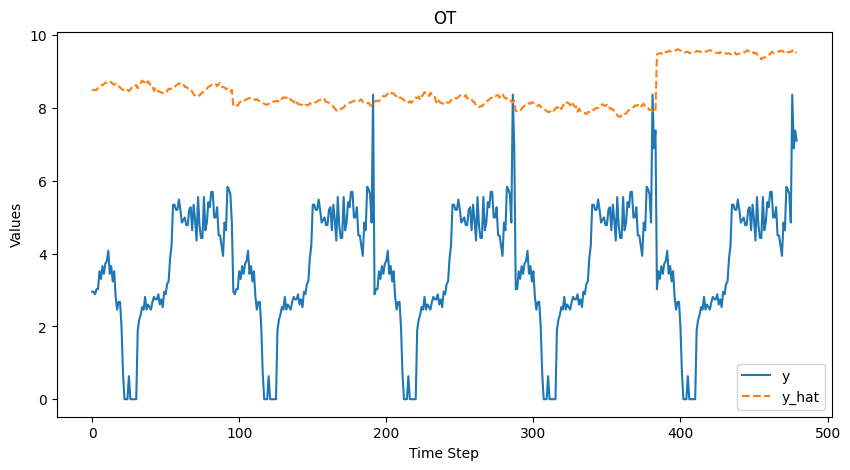

In [ ]:
LSTM_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                          yhat=LSTM_uni2uni_manager.predict(uni2uni_loader.test_loader),
                          feature_names=uni2uni_loader.out_features,
                          save_dir=os.path.join(plot_dir, sub_dir),
                          save_plots=True,
                          num_elements=ele)

### **BiLSTM**

In [ ]:
BiLSTM_uni2uni = BiLSTM(input_size=uni2uni_loader.in_variable,
                        hidden_size=hidden_size,
                        output_size=uni2uni_loader.out_variable,
                        ahead=label_size,
                        num_layers=num_layers)
BiLSTM_uni2uni_manager = ModelManager(model=BiLSTM_uni2uni,
                                      train_loader=uni2uni_loader.train_loader,
                                      val_loader=uni2uni_loader.val_loader,
                                      lr=learning_rate,
                                      patience=patience)
BiLSTM_uni2uni_manager.train(num_epochs=num_epochs,
                             save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

Model saved to weights\uni2uni\best-BiLSTM.pth
Epoch [1/1000000], time: 111s, loss: 8.5252, val_loss: 11.0617
Model saved to weights\uni2uni\best-BiLSTM.pth
Epoch [2/1000000], time: 111s, loss: 4.9841, val_loss: 6.2479
Model saved to weights\uni2uni\best-BiLSTM.pth
Epoch [3/1000000], time: 112s, loss: 3.9586, val_loss: 5.8016
Epoch [4/1000000], time: 114s, loss: 3.5946, val_loss: 6.4067
Model saved to weights\uni2uni\best-BiLSTM.pth
Epoch [5/1000000], time: 114s, loss: 3.3119, val_loss: 5.7135
Model saved to weights\uni2uni\best-BiLSTM.pth
Epoch [6/1000000], time: 113s, loss: 3.1759, val_loss: 5.4267
Epoch [7/1000000], time: 113s, loss: 3.0074, val_loss: 5.7697
Epoch [8/1000000], time: 113s, loss: 2.9617, val_loss: 5.7917
Epoch [9/1000000], time: 113s, loss: 2.9265, val_loss: 5.6199
Epoch [10/1000000], time: 113s, loss: 2.9238, val_loss: 5.7444
Epoch [11/1000000], time: 113s, loss: 2.8876, val_loss: 5.5956
Epoch [12/1000000], time: 114s, loss: 2.8854, val_loss: 5.7760
Epoch [13/1000000

{'Name': 'BiLSTM', 'Type': 'uni2uni', 'MAE': 3.0088028536902534}

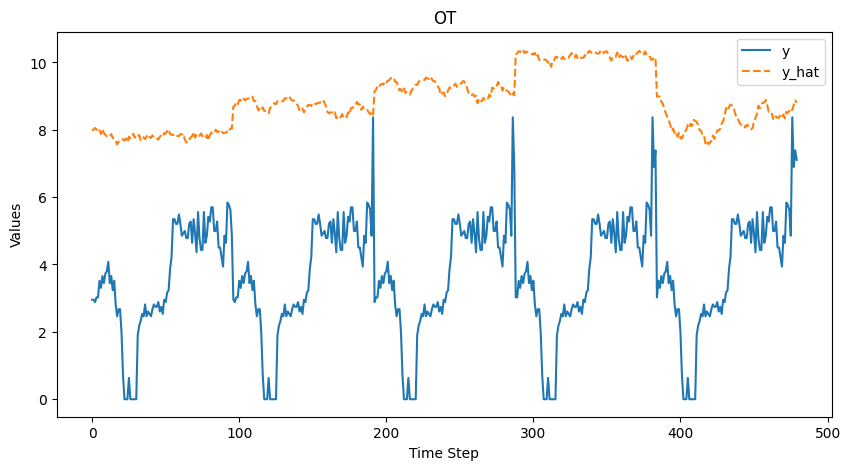

In [ ]:
BiLSTM_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                            yhat=BiLSTM_uni2uni_manager.predict(uni2uni_loader.test_loader),
                            feature_names=uni2uni_loader.out_features,
                            save_dir=os.path.join(plot_dir, sub_dir),
                            save_plots=True,
                            num_elements=ele)

### **XGBoost**

In [ ]:
XGBoost_uni2uni = XGBRegressor(**xgboost_config)
XGBoost_uni2uni_manager = MachineLearningModelManager(model=XGBoost_uni2uni,
                                                      xtrain=uni2uni_loader.X_train,
                                                      ytrain=uni2uni_loader.y_train,
                                                      xval=uni2uni_loader.X_val,
                                                      yval=uni2uni_loader.y_val)
XGBoost_uni2uni_manager.train(save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": XGBoost_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_uni2uni_manager.evaluate(x=uni2uni_loader.X_test, y=uni2uni_loader.y_test)
})
results[-1]

[0]	validation_0-mae:2.54231
[1]	validation_0-mae:2.15640
[2]	validation_0-mae:1.95173
[3]	validation_0-mae:1.89940
[4]	validation_0-mae:1.94982
[5]	validation_0-mae:2.08652
[6]	validation_0-mae:2.28279
[7]	validation_0-mae:2.51080
[8]	validation_0-mae:2.74705
[9]	validation_0-mae:2.98389
[10]	validation_0-mae:3.20893
[11]	validation_0-mae:3.41141
[12]	validation_0-mae:3.60215
[13]	validation_0-mae:3.77230
[14]	validation_0-mae:3.92033
[15]	validation_0-mae:4.06023
[16]	validation_0-mae:4.19277
[17]	validation_0-mae:4.30745
[18]	validation_0-mae:4.41087
[19]	validation_0-mae:4.50990
[20]	validation_0-mae:4.59327
[21]	validation_0-mae:4.67500
[22]	validation_0-mae:4.74851
[23]	validation_0-mae:4.81940
Model saved to weights\uni2uni\best-XGBRegressor.pkl


{'Name': 'XGBRegressor', 'Type': 'uni2uni', 'MAE': 5.014621265340637}

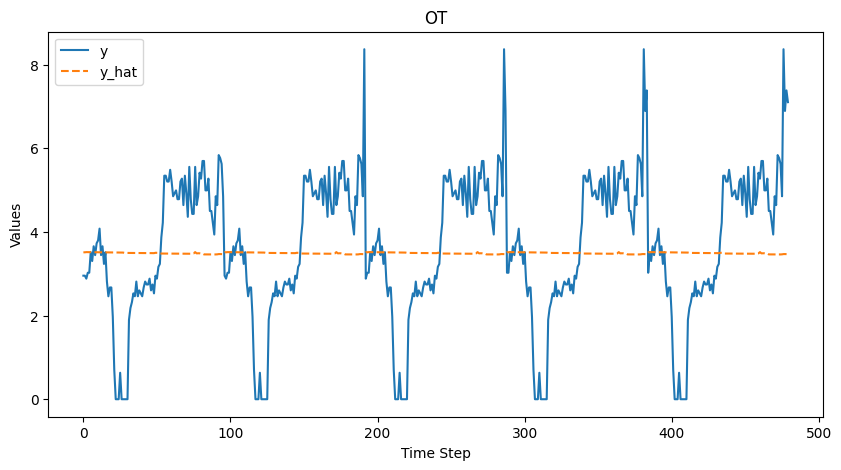

In [ ]:
XGBoost_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                             yhat=XGBoost_uni2uni_manager.predict(uni2uni_loader.X_test),
                             feature_names=uni2uni_loader.out_features,
                             save_dir=os.path.join(plot_dir, sub_dir),
                             save_plots=True,
                             num_elements=ele)

# **Results**

In [ ]:
pl.from_dicts(results)

shape: (15, 3)
┌──────────────┬─────────────┬──────────┐
│ Name         ┆ Type        ┆ MAE      │
│ ---          ┆ ---         ┆ ---      │
│ str          ┆ str         ┆ f64      │
╞══════════════╪═════════════╪══════════╡
│ MLP          ┆ multi2multi ┆ 2.4726   │
│ RNN          ┆ multi2multi ┆ 2.211064 │
│ LSTM         ┆ multi2multi ┆ 2.290056 │
│ BiLSTM       ┆ multi2multi ┆ 2.561954 │
│ …            ┆ …           ┆ …        │
│ RNN          ┆ uni2uni     ┆ 2.802259 │
│ LSTM         ┆ uni2uni     ┆ 2.565957 │
│ BiLSTM       ┆ uni2uni     ┆ 3.008803 │
│ XGBRegressor ┆ uni2uni     ┆ 5.014621 │
└──────────────┴─────────────┴──────────┘